### Basic neural activity analysis with single camera tracking
#### analyze the firing rate PC1,2,3
#### making the demo videos
#### analyze the spike triggered pull and gaze ditribution
#### the following detailed analysis focused on pull related behavioral events; with the specific focus on the partner Distance variables
#### the pull action start events are defined based on the movement onset before each pull

In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from dPCA import dPCA
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

from scipy.ndimage import label


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam import plot_continuous_bhv_var_singlecam
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [11]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [12]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [13]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

### function - other useful functions

In [14]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [15]:
# get useful information about pulls
from ana_functions.get_pull_infos import get_pull_infos

In [16]:
# use the gaze vector speed and face mass speed to find the pull action start time within IPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI_dual_speed

In [17]:
# method 2: find the lowest timepoint then the increase point as the pull onset
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_withinIPI
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_dual_speed

In [18]:
# methods 3: based on the HMM fitting
from ana_functions.get_trial_start_frames_from_hmm_states import get_trial_start_frames_from_HMM
from ana_functions.get_trial_start_frames_from_hmm_states import get_trial_start_frames_from_hmm_states


## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [146]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 0:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

pull1_intv_all_dates = np.zeros((ndates,1))
pull2_intv_all_dates = np.zeros((ndates,1))
pull1_minintv_all_dates = np.zeros((ndates,1))
pull2_minintv_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])

pull_infos_all_dates = dict.fromkeys(dates_list, []) # keep some useful information about pulls - time from last reward, number of preceding failed pull etc

pull_rts_all_dates = dict.fromkeys(dates_list, [])

pullstart_trig_events_all_dates = dict.fromkeys(dates_list, [])
succpullstart_trig_events_all_dates = dict.fromkeys(dates_list, [])
failpullstart_trig_events_all_dates = dict.fromkeys(dates_list, [])

bhvevents_pullstart_aligned_FR_all_dates = dict.fromkeys(dates_list, [])
bhvevents_pullstart_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [147]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)


In [148]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # dummy
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/pull1_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/pull_infos_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull_infos_all_dates  = pickle.load(f)  
        
    with open(data_saved_subfolder+'/pull_rts_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull_rts_all_dates  = pickle.load(f)
        
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/pullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pullstart_trig_events_all_dates = pickle.load(f)    
    with open(data_saved_subfolder+'/succpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succpullstart_trig_events_all_dates = pickle.load(f)    
    with open(data_saved_subfolder+'/failpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        failpullstart_trig_events_all_dates = pickle.load(f)    
    
        
    with open(data_saved_subfolder+'/bhvevents_pullstart_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_pullstart_aligned_FR_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/bhvevents_pullstart_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_pullstart_aligned_FR_allevents_all_dates = pickle.load(f) 
        
        
    print('all data from all dates are loaded; pull start focus')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]

        #
        pull_rts_all_dates[date_tgt] = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
        
        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # successful trial or not
        succtrial_ornot = np.array((trial_record['rewarded']>0).astype(int))
        succpull1_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==1]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpull2_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==2]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpulls_ornot = [succpull1_ornot,succpull2_ornot]
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        if np.isin(animal1,animal1_fixedorder):
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
        else:
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1)

        #
        pulltime1 = np.array(bhv_data[(bhv_data['behavior_events']==1)]['time_points'])
        pulltime2 = np.array(bhv_data[(bhv_data['behavior_events']==2)]['time_points'])
        # 
        if np.isin(animal1,animal1_fixedorder):
            try:
                pull1_intv_all_dates[idate] = np.nanmean(pulltime1[1:]-pulltime1[0:-1])
                pull1_minintv_all_dates[idate] = np.nanmin(pulltime1[1:]-pulltime1[0:-1])
            except:
                pull1_intv_all_dates[idate] = np.nan
                pull1_minintv_all_dates[idate] = np.nan
            try:
                pull2_intv_all_dates[idate] = np.nanmean(pulltime2[1:]-pulltime2[0:-1])
                pull2_minintv_all_dates[idate] = np.nanmin(pulltime2[1:]-pulltime2[0:-1])
            except:
                pull2_intv_all_dates[idate] = np.nan
                pull2_minintv_all_dates[idate] = np.nan
        else:
            try:
                pull1_intv_all_dates[idate] = np.nanmean(pulltime2[1:]-pulltime2[0:-1])
                pull1_minintv_all_dates[idate] = np.nanmin(pulltime2[1:]-pulltime2[0:-1])
            except:
                pull1_intv_all_dates[idate] = np.nan
                pull1_minintv_all_dates[idate] = np.nan
            try:
                pull2_intv_all_dates[idate] = np.nanmean(pulltime1[1:]-pulltime1[0:-1])
                pull2_minintv_all_dates[idate] = np.nanmin(pulltime1[1:]-pulltime1[0:-1])
            except:
                pull2_intv_all_dates[idate] = np.nan
                pull2_minintv_all_dates[idate] = np.nan
        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        
        # make sure all task code registered event, aka pulls, are within the video recording
        ind_good_pull1 = time_point_pull1 < (totalsess_time - session_start_time)
        time_point_pull1 = time_point_pull1[ind_good_pull1]
        ind_good_pull2 = time_point_pull2 < (totalsess_time - session_start_time)
        time_point_pull2 = time_point_pull2[ind_good_pull2]
        
            
        # define successful pulls and failed pulls
        if 0: # old definition; not in use
            trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
            bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
            #
            time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
            time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
            time_point_pull1_succ = np.round(time_point_pull1_succ,1)
            time_point_pull2_succ = np.round(time_point_pull2_succ,1)
            #
            trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
            bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
            #
            time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
            time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
            time_point_pull1_fail = np.round(time_point_pull1_fail,1)
            time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        else:
            # a new definition of successful and failed pulls
            # separate successful and failed pulls
            # step 1 all pull and juice
            time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
            time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
            time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
            time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
            # step 2:
            # pull 1
            # Find the last pull before each juice
            successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
            # Convert to Pandas Series
            successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
            # pull 2
            # Find the last pull before each juice
            successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
            # Convert to Pandas Series
            successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
            #
            # step 3:
            time_point_pull1_succ = np.round(successful_pull1,1)
            time_point_pull2_succ = np.round(successful_pull2,1)
            time_point_pull1_fail = np.round(failed_pull1,1)
            time_point_pull2_fail = np.round(failed_pull2,1)
        #
        # make sure all task code registered event, aka pulls, are within the video recording
        ind_good_pull1 = time_point_pull1 < (totalsess_time - session_start_time)
        time_point_pull1 = time_point_pull1[ind_good_pull1]
        ind_good_pull2 = time_point_pull2 < (totalsess_time - session_start_time)
        time_point_pull2 = time_point_pull2[ind_good_pull2]
        #
        ind_good_pull1_succ = time_point_pull1_succ < (totalsess_time - session_start_time)
        time_point_pull1_succ = time_point_pull1_succ[ind_good_pull1_succ]
        ind_good_pull2_succ = time_point_pull2_succ < (totalsess_time - session_start_time)
        time_point_pull2_succ = time_point_pull2_succ[ind_good_pull2_succ]
        #
        ind_good_pull1_fail = time_point_pull1_fail < (totalsess_time - session_start_time)
        time_point_pull1_fail = time_point_pull1_fail[ind_good_pull1_fail]
        ind_good_pull2_fail = time_point_pull2_fail < (totalsess_time - session_start_time)
        time_point_pull2_fail = time_point_pull2_fail[ind_good_pull2_fail]
        
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        pull_infos_all_dates[date_tgt] = pull_infos
        
            
        #
        if np.isin(animal1,animal1_fixedorder):
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
        else:            
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            

        # define variables and use them to find the 'onset' of pull decision
        print('use the gaze vector speed and face mass speed to define the start of the pull decision')
        #
        gausKernelsize = 16
        #
        # clean the data
        time_point_pull1_temp = np.array(time_point_pull1)+session_start_time
        time_point_pull1_temp = time_point_pull1_temp[time_point_pull1_temp<totalsess_time]
        time_point_pull2_temp = np.array(time_point_pull2)+session_start_time
        time_point_pull2_temp = time_point_pull2_temp[time_point_pull2_temp<totalsess_time]
        #
        # organize the data into a time series
        pull1_data = np.zeros([int(totalsess_time*fps),])
        pull1_data[np.round(time_point_pull1_temp*fps).astype(int)]=1
        #
        pull2_data = np.zeros([int(totalsess_time*fps),])
        pull2_data[np.round(time_point_pull2_temp*fps).astype(int)]=1
        #
        facemass1 = output_key_locations['facemass_loc_all_merge']['dodson'].transpose()
        facemass1 = np.hstack((facemass1,[[np.nan],[np.nan]]))
        at1_min_at0 = (facemass1[:,1:]-facemass1[:,:-1])
        speed1_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
        speed1_data = scipy.ndimage.gaussian_filter1d(speed1_data,gausKernelsize)
        #
        facemass2 = output_key_locations['facemass_loc_all_merge']['scorch'].transpose()
        facemass2 = np.hstack((facemass2,[[np.nan],[np.nan]]))
        at1_min_at0 = (facemass2[:,1:]-facemass2[:,:-1])
        speed2_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
        speed2_data = scipy.ndimage.gaussian_filter1d(speed2_data,gausKernelsize)
        #
        gazevect1 = np.array(output_allvectors['head_vect_all_merge']['dodson']).transpose()
        gazevect1 = np.hstack((gazevect1, [[np.nan], [np.nan]]))
        at1 = gazevect1[:, 1:]
        at0 = gazevect1[:, :-1] 
        nframes = np.shape(at1)[1]
        anglespeed1_data = np.full(nframes, np.nan)
        eps = 1e-10
        for iframe in np.arange(0, nframes, 1):
            norm1 = np.linalg.norm(at1[:, iframe]) + eps
            norm0 = np.linalg.norm(at0[:, iframe]) + eps
            dot_val = np.dot(at1[:, iframe]/norm1, at0[:, iframe]/norm0)
            anglespeed1_data[iframe] = np.arccos(np.clip(dot_val, -1.0, 1.0))    
        # fill NaNs
        nans = np.isnan(anglespeed1_data)
        if np.any(~nans):
            anglespeed1_data[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), anglespeed1_data[~nans])
        anglespeed1_data = scipy.ndimage.gaussian_filter1d(anglespeed1_data, gausKernelsize)
        #
        gazevect2 = np.array(output_allvectors['head_vect_all_merge']['scorch']).transpose()
        gazevect2 = np.hstack((gazevect2, [[np.nan], [np.nan]]))
        at1 = gazevect2[:, 1:]
        at0 = gazevect2[:, :-1] 
        nframes = np.shape(at1)[1]
        anglespeed2_data = np.full(nframes, np.nan)
        for iframe in np.arange(0, nframes, 1):
            norm1 = np.linalg.norm(at1[:, iframe]) + eps
            norm0 = np.linalg.norm(at0[:, iframe]) + eps
            dot_val = np.dot(at1[:, iframe]/norm1, at0[:, iframe]/norm0)
            anglespeed2_data[iframe] = np.arccos(np.clip(dot_val, -1.0, 1.0))    
        # fill NaNs
        nans = np.isnan(anglespeed2_data)
        if np.any(~nans):
            anglespeed2_data[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), anglespeed2_data[~nans])
        anglespeed2_data = scipy.ndimage.gaussian_filter1d(anglespeed2_data, gausKernelsize)
        
        # find the transitional time point of angle speed and speed in IPI
        speed1_increase = find_sharp_increases_withinIPI(pull1_data,speed1_data,session_start_time,fps)
        anglespeed1_increase = find_sharp_increases_withinIPI(pull1_data,anglespeed1_data,session_start_time,fps)
        # find the transitional time point using both angle speed and mass speed in IPI
        pull1_action_onset_frames = find_sharp_increases_withinIPI_dual_speed(pull1_data, speed1_data, anglespeed1_data, 
                                                                              session_start_time, fps)
        #
        speed2_increase = find_sharp_increases_withinIPI(pull2_data,speed2_data,session_start_time,fps)
        anglespeed2_increase = find_sharp_increases_withinIPI(pull2_data,anglespeed2_data,session_start_time,fps)
        # find the transitional time point using both angle speed and mass speed in IPI
        pull2_action_onset_frames = find_sharp_increases_withinIPI_dual_speed(pull2_data, speed2_data, anglespeed2_data, 
                                                                              session_start_time, fps)
         
        #
        # store the pull reaction time information
        pull_data_points = np.where(pull1_data)[0]
        pullonset_data_points = np.where(pull1_action_onset_frames)[0]
        pull1_rt = (pull_data_points - pullonset_data_points)/fps
        pull_rts_all_dates[date_tgt][animal1] = pull1_rt
        #
        pull_data_points = np.where(pull2_data)[0]
        pullonset_data_points = np.where(pull2_action_onset_frames)[0]
        pull2_rt = (pull_data_points - pullonset_data_points)/fps
        pull_rts_all_dates[date_tgt][animal2] = pull2_rt
        
        
        #
        # replace time_point_pull_xxx to the pull onset
        time_point_pull1 = np.array(np.round(time_point_pull1,1))
        time_point_pull2 = np.array(np.round(time_point_pull2,1))
        time_point_pull1_succ = np.array(time_point_pull1_succ)
        time_point_pull2_succ = np.array(time_point_pull2_succ)
        time_point_pull1_fail = np.array(time_point_pull1_fail)
        time_point_pull2_fail = np.array(time_point_pull2_fail)
        #
        time_point_pull1_succ_idx = np.isin(time_point_pull1,time_point_pull1_succ)
        time_point_pull2_succ_idx = np.isin(time_point_pull2,time_point_pull2_succ)
        time_point_pull1_fail_idx = np.isin(time_point_pull1,time_point_pull1_fail)
        time_point_pull2_fail_idx = np.isin(time_point_pull2,time_point_pull2_fail)
        #
        time_point_pull1 = np.where(pull1_action_onset_frames)[0]/fps - session_start_time
        time_point_pull2 = np.where(pull2_action_onset_frames)[0]/fps - session_start_time
        #
        time_point_pull1_succ = time_point_pull1[time_point_pull1_succ_idx]
        time_point_pull2_succ = time_point_pull2[time_point_pull2_succ_idx]
        time_point_pull1_fail = time_point_pull1[time_point_pull1_fail_idx]
        time_point_pull2_fail = time_point_pull2[time_point_pull2_fail_idx]
        
        
        # plot key continuous behavioral variables
        if 1:
            print('plot self pull start triggered bhv variables')
            
            filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+cameraID+'/'+date_tgt+'/'
            if not os.path.exists(filepath_cont_var):
                os.makedirs(filepath_cont_var)

            savefig = 0
            
            aligntwins = 4 # 5 second
            
            min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording

            # NOTE! This one used the wrong and old version of separating successful and failed 
            pull_trig_events_summary, _, _ = plot_continuous_bhv_var_singlecam(filepath_cont_var+date_tgt+cameraID,
                                    aligntwins, savefig, animal1, animal2, 
                                    session_start_time, min_length, succpulls_ornot, time_point_pull1, time_point_pull2, 
                                    oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                    output_look_ornot, output_allvectors, output_allangles,output_key_locations)
            pullstart_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            
            # successful pull
            try:
                pull_trig_events_summary, _, _ = plot_continuous_bhv_var_singlecam(filepath_cont_var+date_tgt+cameraID,
                                        aligntwins, savefig, animal1, animal2, 
                                        session_start_time, min_length, succpulls_ornot, 
                                        time_point_pull1_succ, time_point_pull2_succ, 
                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                succpullstart_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            except:
                succpullstart_trig_events_all_dates[date_tgt] = np.nan
            
            # failed pull
            try:
                pull_trig_events_summary, _, _ = plot_continuous_bhv_var_singlecam(filepath_cont_var+date_tgt+cameraID,
                                        aligntwins, savefig, animal1, animal2, 
                                        session_start_time, min_length, succpulls_ornot, 
                                        time_point_pull1_fail, time_point_pull2_fail, 
                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                failpullstart_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            except:
                failpullstart_trig_events_all_dates[date_tgt] = np.nan
                
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 0:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)
            # behavioral events aligned firing rate for each unit
            if 1: 
                print('plot event aligned firing rate; pull start focus')
                #
                savefig = 0
                save_path = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents/"+cameraID+"/"+\
                            animal1_filename+"_"+animal2_filename+'_'+recordedanimal+'Recorded'+"/"+date_tgt
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                #
                aligntwins = 4 # 5 second
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                bhvevents_aligned_FR_average_all,bhvevents_aligned_FR_allevents_all = plot_bhv_events_aligned_FR(date_tgt,savefig,save_path, animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           aligntwins,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                bhvevents_pullstart_aligned_FR_all_dates[date_tgt] = bhvevents_aligned_FR_average_all
                bhvevents_pullstart_aligned_FR_allevents_all_dates[date_tgt] = bhvevents_aligned_FR_allevents_all
                
                
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)
            
        with open(data_saved_subfolder+'/pull1_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull2_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull1_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull2_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_intv_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull_infos_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_infos_all_dates, f)   
            
        with open(data_saved_subfolder+'/pull_rts_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_rts_all_dates, f)   
            
        with open(data_saved_subfolder+'/pullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pullstart_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/succpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succpullstart_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/failpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(failpullstart_trig_events_all_dates, f) 
            
        with open(data_saved_subfolder+'/bhvevents_pullstart_aligned_FR_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_pullstart_aligned_FR_all_dates, f) 
        with open(data_saved_subfolder+'/bhvevents_pullstart_aligned_FR_allevents_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_pullstart_aligned_FR_allevents_all_dates, f) 
            
    
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
    
            
        with open(data_saved_subfolder+'/pullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pullstart_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/succpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succpullstart_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/failpullstart_trig_events_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(failpullstart_trig_events_all_dates, f) 
            
    
   
    

loading all data
all data from all dates are loaded; pull start focus


In [149]:
# np.shape(failpull_trig_events_all_dates['20240606'][('dannon', 'gaze_other_angle')])


In [150]:
# pull1_intv_all_dates[np.isin(task_conditions,['MC','MC_withGinger','MC_withDodson','MC_withKoala','MC_withVermelho'])]

In [151]:
# pull_infos_all_dates['20240613'].keys()
pull_infos_all_dates.keys()

dict_keys(['20240531', '20240603_MC', '20240603_SR', '20240604', '20240605_MC', '20240605_SR', '20240606_MC', '20240606_SR', '20240607', '20240610_MC', '20240611', '20240612', '20240613', '20240620', '20240719', '20250129', '20250130', '20250131', '20250210', '20250211', '20250212', '20250214', '20250217', '20250218', '20250219', '20250220', '20250224', '20250226', '20250227', '20250228', '20250304', '20250305', '20250306', '20250307', '20250310', '20250312', '20250313', '20250314', '20250401', '20250402', '20250403', '20250404', '20250407', '20250408', '20250409', '20250415', '20250417', '20250418', '20250421', '20250422', '20250422_SR', '20250423', '20250423_SR', '20250424', '20250424_MC', '20250424_SR', '20250425', '20250425_SR', '20250428_NV', '20250428_MC', '20250428_SR', '20250429_NV', '20250429_MC', '20250429_SR', '20250430_NV', '20250430_MC', '20250430_SR'])

In [152]:
# pull_trig_events_all_dates['20240508'].keys()
# pull_trig_events_all_dates['20240531'].keys()
# pull_trig_events_all_dates['20240613'][('kanga', 'otherpull_prob')]
# np.shape(pull_trig_events_all_dates['20240613'][('kanga', 'otherpull_prob')])
# np.shape(pull_infos_all_dates['20240613'][('kanga', 'num_preceding_failpull')])

#### re-organized the data
#### for the activity aligned at the different single behavioral events, mostly focus on self pull
#### the ultamate goal is to analyze the difference in single trial and if gaze related variables related to any of them
#### make some prilimary plot for sanity check

In [153]:

# choose one pull_trig_events type to work with
# options: ['gaze_other_angle','gaze_tube_angle','gaze_lever_angle','animal_animal_dist',
#           'animal_tube_dist','animal_lever_dist','othergaze_self_angle',
#           'mass_move_speed','gaze_angle_speed','otherani_otherlever_dist','otherani_othertube_dist',
#           'socialgaze_prob','othergaze_prob']
#

# use this variable as the main target to estimate the partner's intention 
#
# pull_trig_events_tgtname = 'otherpull_prob' 
# pull_trig_events_tgtname = 'otherani_otherlever_dist' 
# pull_trig_events_tgtname = 'animal_lever_dist' 
# pull_trig_events_tgtname = 'otherani_othertube_dist' 
# pull_trig_events_tgtname = 'animal_tube_dist' 
# pull_trig_events_tgtname = 'animal_animal_dist' 
# pull_trig_events_tgtname = 'other_mass_move_speed'

# change it to a list to work with 
#
# List of pull_trig_events types to load
pull_trig_events_tgtnames = [
    'other_mass_move_speed', 
    'otherani_otherlever_dist',
    'animal_animal_dist', 
    # 'mass_move_speed',
]
# only keep one for the further analysis
pull_trig_events_tgtname = 'other_mass_move_speed'

# Keep these as additional controls
pull_trig_gazeprob_name = 'socialgaze_prob'
pull_trig_otherpull_name = 'otherpull_prob'
pull_trig_selfpull_name = 'selfpull_prob'
pull_num_pre_failpull_name = 'num_preceding_failpull'
pull_time_pre_reward_name = 'time_from_last_reward'
pull_rt_name = 'pull_rt'


bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=[
                                                    'dates', 'condition', 'act_animal', 'bhv_name',
                                                    'succrate', 'clusterID', 'channelID', 'FR_allevents'
                                                ])
bhvevents_aligned_FR_all_dates_df = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name',
                                            'succrate', 'clusterID', 'channelID', 'FR_average'
                                        ])

for idate in np.arange(0, ndates, 1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]
    succrate = succ_rate_all_dates[idate]
    bhv_types = list(bhvevents_pullstart_aligned_FR_allevents_all_dates[date_tgt].keys())

    for ibhv_type in bhv_types:
        clusterIDs = list(bhvevents_pullstart_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())

        ibhv_type_split = ibhv_type.split()
        if len(ibhv_type_split) == 3:
            ibhv_type_split[1] = ibhv_type_split[1] + '_' + ibhv_type_split[2]

        event_dict = {}
        def load_event(source_dict, actor, name):
            try:
                return source_dict[date_tgt][(actor, name)]
            except:
                return np.nan

        # determine which dataset to use
        if ibhv_type_split[1] == 'pull':
            source = pullstart_trig_events_all_dates
        elif ibhv_type_split[1] == 'succpull':
            source = succpullstart_trig_events_all_dates
        elif ibhv_type_split[1] == 'failpull':
            source = failpullstart_trig_events_all_dates
        else:
            source = None

        if source is not None:
            actor = ibhv_type_split[0]
            for name in pull_trig_events_tgtnames:
                event_dict[name] = load_event(source, actor, name)
            
            event_dict[pull_trig_gazeprob_name] = load_event(source, actor, pull_trig_gazeprob_name)
            event_dict[pull_trig_otherpull_name] = load_event(source, actor, pull_trig_otherpull_name)
            event_dict[pull_trig_selfpull_name] = load_event(source, actor, pull_trig_selfpull_name)
        else:
            for name in pull_trig_events_tgtnames + [
                pull_trig_gazeprob_name, pull_trig_otherpull_name, pull_trig_selfpull_name
            ]:
                event_dict[name] = np.nan
                
        # for the pull information variables
        #
        source2 = pull_infos_all_dates
        event_dict[pull_num_pre_failpull_name] = load_event(source2, actor, pull_num_pre_failpull_name)
        event_dict[pull_time_pre_reward_name] = load_event(source2, actor, pull_time_pre_reward_name)
        #
        event_dict[pull_rt_name] = np.array(list(pull_rts_all_dates[date_tgt][actor]))
        
        #
        for iclusterID in clusterIDs:
            ichannelID = bhvevents_pullstart_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_pullstart_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']

            row_data = {
                'dates': date_tgt,
                'condition': task_condition,
                'act_animal': ibhv_type_split[0],
                'bhv_name': ibhv_type_split[1],
                'succrate': succrate,
                'clusterID': iclusterID,
                'channelID': ichannelID,
                'FR_allevents': iFR_average
            }
            # Add all events into the row
            row_data.update(event_dict)
            bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append(
                row_data, ignore_index=True
            )

            # Also add to FR_average table
            ichannelID = bhvevents_pullstart_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
            iFR_average = bhvevents_pullstart_aligned_FR_all_dates[date_tgt][ibhv_type][iclusterID]['FR_average']

            bhvevents_aligned_FR_all_dates_df = bhvevents_aligned_FR_all_dates_df.append({
                'dates': date_tgt,
                'condition': task_condition,
                'act_animal': ibhv_type_split[0],
                'bhv_name': ibhv_type_split[1],
                'succrate': succrate,
                'clusterID': iclusterID,
                'channelID': ichannelID,
                'FR_average': iFR_average
            }, ignore_index=True)

                


In [154]:
bhvevents_aligned_FR_allevents_all_dates_df.keys()

Index(['dates', 'condition', 'act_animal', 'bhv_name', 'succrate', 'clusterID',
       'channelID', 'FR_allevents', 'animal_animal_dist',
       'num_preceding_failpull', 'other_mass_move_speed',
       'otherani_otherlever_dist', 'otherpull_prob', 'pull_rt',
       'selfpull_prob', 'socialgaze_prob', 'time_from_last_reward'],
      dtype='object')

In [155]:
np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])

array(['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
       'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 'NV_withKanga',
       'NV_withKoala', 'SR', 'SR_withGingerNew', 'SR_withKanga',
       'SR_withKoala'], dtype=object)

In [156]:
# act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
# act_animals_to_ana = ['kanga']
act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
# bhv_names_to_ana = ['succpull','failpull']
# bhv_names_to_ana = ['failpull']
# bhv_names_to_ana = ['succpull']
bhv_names_to_ana = ['pull']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['SR']
# conditions_to_ana = ['MC_DannonAuto']
#
# for Kanga only
# conditions_to_ana = ['MC', 'MC_DannonAuto', 'MC_KangaAuto', 'MC_withDodson','MC_withGinger', 
#                      'MC_withKoala', 'MC_withVermelho', 'NV', ]
# 
# for dodson only
# conditions_to_ana = ['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
# 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]


nconds_to_ana = np.shape(conditions_to_ana)[0]

### sanity check plot; focus on bhv only
#### look at the relationship among pull_trig_events_tgtname (the variable that aim to explore other's intention), otherpull_prob (aligned at self pull), selfpull_prob, and socialgaze accumulation related quantification to see which variables correlated with self gaze accumulation the most and identify the best variables for estimating intention

/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.na

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.na

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.na

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.na

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line
no regression line
Not enough data for multivariable regression on 20250430_NV, NV_withKanga, dodson, pull
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

Not enough data for multivariable regression on 20250313, NV_withKoala, dodson, pull


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/sc

no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_s

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm 

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm 

no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm 

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:223: RuntimeWarning: Mean of empty slice
  tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_4052140/2068805627.py:207: RuntimeWarning: Mean of empty slice
  tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
/tmp/ipykernel_4052140/2068805627.py:221: RuntimeWarning: Mean of empty slice
  tgt_meanvelocity = np.nanmean(tgt_ve

no regression line
no regression line


/tmp/ipykernel_4052140/2068805627.py:132: RuntimeWarning: All-NaN axis encountered
  reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])


no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm 

no regression line
no regression line


/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm 

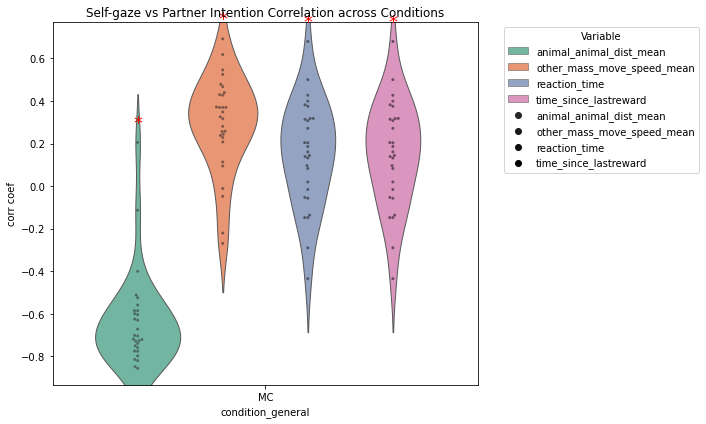

In [157]:
if 1:
    # only look at pull aligned events that has no preceding self pull 
    doSingleSelfPulls = 1
    
    # define which time window will be analyzed
    gaze_duration_type = 'after_pull' # 'around_pull', 'before_pull', 'after_pull'

    # time window time points
    x_full = np.arange(-4, 4, 1/fps)
    #
    if gaze_duration_type == 'before_pull':
        # Only use the pre-pull window (-4s to 0s)
        pre_mask = x_full <= -0.15
    elif gaze_duration_type == 'after_pull':
        # Only use the post-pull window (0s to 4s)
        pre_mask = x_full >= 0.15
    elif gaze_duration_type == 'around_pull':
        # the entire -4 to 4s
        pre_mask = (x_full <= 0)|(x_full >= 0) 
    
    # sampling interval in seconds
    dt = 1 / fps  # sampling interval in seconds
    
    # initialize some dataframe for saving data
    bhvevents_aligned_bhvonly_eachevents_df = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name', 'bhv_id',
                                        ])
    selfgaze_partnerIntention_corr_df = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name', 'selfgazeVarName',
                                        ])
    selfgaze_partnerIntention_multivar_corr_df = pd.DataFrame(columns=[
                                            'dates', 'condition', 'act_animal', 'bhv_name',
                                        ])
    
    
    # load the data 
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana

                # get the neurons 
                neurons_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]


                # only look at one neuron since it's behavioral related exploration
                for ineuron in np.arange(0,1,1):
                # for ineuron in np.arange(0,nneurons,1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron

                    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
                        
                        # self gaze distribution
                        pull_trig_gazeprob_tgt = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [pull_trig_gazeprob_name])[0])
                        # self pull distribution
                        pull_trig_selfpull_tgt = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [pull_trig_selfpull_name])[0])
                        # other pull distribution
                        pull_trig_otherpull_tgt = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [pull_trig_otherpull_name])[0])
                        # number of preceding failed pulls
                        pull_num_pre_failpull_tgt = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [pull_num_pre_failpull_name])[0])
                        # time between the current pull and the previous juice
                        pull_time_pre_reward_tgt = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [pull_time_pre_reward_name])[0])
                        
                        #
                        nevents = np.shape(pull_trig_gazeprob_tgt)[0]
                        
                        for ievent in np.arange(0,nevents,1):
                            
                            # number of preceding failed pulls
                            pull_num_pre_failpull_ievent = pull_num_pre_failpull_tgt[ievent]
                            
                            # time between the current pull and the previous juice
                            pull_time_pre_reward_ievent = pull_time_pre_reward_tgt[ievent]
                            lastreward_time = -pull_time_pre_reward_ievent
                            
                            #
                            # calculate the mean self pull number
                            #
                            from scipy.signal import find_peaks
                            #
                            pull_trig_selfpull_ievent = pull_trig_selfpull_tgt[ievent,:]
                            try:
                                # selfpull_num = np.trapz(pull_trig_selfpull_ievent[pre_mask], dx=dt)
                                data = pull_trig_selfpull_ievent[pre_mask]
                                peaks, _ = find_peaks(data)
                                selfpull_num = len(peaks)
                            except:
                                selfpull_num = np.nan
                            #
                            if selfpull_num > 0:
                                lastselfpull_time = x_full[peaks[-1]]
                            else:
                                lastselfpull_time =  np.nan
                            
                            #
                            # calculate the mean other pull number
                            pull_trig_otherpull_ievent = pull_trig_otherpull_tgt[ievent,:]
                            try:
                                # otherpull_num = np.trapz(pull_trig_otherpull_ievent[pre_mask], dx=dt)
                                data = pull_trig_otherpull_ievent[pre_mask]
                                peaks, _ = find_peaks(data)
                                otherpull_num = len(peaks)
                            except:
                                otherpull_num = np.nan
                                                              
                            #
                            # reaction time: time since last reward or last pull
                            reaction_time = -np.nanmax([lastreward_time, lastselfpull_time])
                            
                            
                            
                            #
                            # calculate the gaze accumulation level
                            pull_trig_gazeprob_ievent = pull_trig_gazeprob_tgt[ievent,:]
                            
                            # 
                            # only consider gaze that's within reaction time
                            if 0:
                                ind_beforeRT = pull_trig_gazeprob_ievent < -reaction_time
                                pull_trig_gazeprob_ievent[ind_beforeRT]=0     
                            #
                            # for the socialgaze_prob, only use the meaningful ones
                            if 0:
                                trace = pull_trig_gazeprob_ievent
                                time_trace = np.arange(-4, 4, 1/30)
                                filtered_trace = keep_closest_cluster_single_trial(trace, time_trace)
                                pull_trig_gazeprob_ievent = filtered_trace
                                
                            
                            #
                            try:
                                gaze_accum = np.trapz(pull_trig_gazeprob_ievent[pre_mask], dx=dt)
                            except:
                                gaze_accum = np.nan
                            # calculate the gaze start stop and duration
                            try:
                                first_increase_idx = np.where(np.diff(pull_trig_gazeprob_ievent) > 0)[0][0] + 1
                                #
                                last_decrease_idx = np.where(np.diff(pull_trig_gazeprob_ievent) < 0)[0][-1] + 1  # Find last decrease
                                #
                                gazestart_time = x_full[first_increase_idx].copy()
                                gazestop_time = x_full[last_decrease_idx].copy()
                                #    
                                # change the gazestart and gazestop time based on the gaze duration definition
                                if gaze_duration_type == 'around_pull':
                                    gazestart_time = gazestart_time
                                    gazestop_time = gazestop_time
                                if gaze_duration_type == 'before_pull':
                                    if (gazestart_time > 0):
                                        gazestart_time = np.nan
                                        gazestop_time = np.nan
                                    elif (gazestop_time > 0):
                                        gazestop_time = 0
                                if gaze_duration_type == 'after_pull':
                                    if (gazestop_time < 0):
                                        gazestart_time = np.nan
                                        gazestop_time = np.nan
                                    elif (gazestart_time < 0):
                                        gazestart_time = 0                                                
                                #
                                # if (gazestart_time == timewins[0]) | (gazestart_time == timewins[-1]):
                                #     gazestart_time = np.nan
                                # if (gazestop_time == timewins[0]) | (gazestop_time == timewins[-1]):
                                #     gazestop_time = np.nan
                                if (gazestop_time < gazestart_time):
                                    gazestart_time = np.nan
                                    gazestop_time = np.nan                           
                            except:
                                gazestart_time = np.nan
                                gazestop_time = np.nan
                            
                            
                            
                                
                            #
                            # for variables in the pull_trig_events_tgtnames do some more detailed analysis to define metrics
                            event_dict = {}
                            for name in pull_trig_events_tgtnames:
                                pull_trig_tgt_ievent = np.array(np.array(bhvevents_aligned_FR_allevents_tgt\
                                                          [name])[0])[ievent]
                                
                                # calculate the mean value
                                tgt_mean = np.nanmean(pull_trig_tgt_ievent[pre_mask])
                                event_dict[name+'_mean'] = tgt_mean
                                
                                # more detailed metric
                                if (name == 'otherani_otherlever_dist') | \
                                   (name == 'animal_lever_dist') | \
                                   (name == 'otherani_othertube_dist') | \
                                   (name == 'animal_tube_dist') | \
                                   (name == 'animal_animal_dist') :

                                    tgt_velocity = np.gradient(pull_trig_tgt_ievent, 1/fps)
                                    #
                                    tgt_speed = np.abs(tgt_velocity)
                                    #
                                    tgt_meanvelocity = np.nanmean(tgt_velocity[pre_mask])
                                    #
                                    tgt_meanspeed = np.nanmean(tgt_speed[pre_mask])

                                    min_dist = x_full[np.argmin(pull_trig_tgt_ievent)]
                                    max_dist = x_full[np.argmax(pull_trig_tgt_ievent)]
                                    #
                                    pre_min_mask = x_full <= min_dist

                                    # find the time that the dramatic change starts, if could not find it, use the -4s
                                    percentile = 95
                                    dt = 1 / fps
                                    abs_derivative = np.abs(np.gradient(pull_trig_tgt_ievent[x_full <= 0], dt))
                                    threshold = np.percentile(abs_derivative, percentile)
                                    # Start from the first time point (index 0)
                                    idx_change = np.where(abs_derivative > threshold)[0]
                                    if len(idx_change) > 0:
                                        onset_idx = idx_change[0]
                                        change_time = x_full[x_full <= 0][onset_idx]
                                    else:
                                        change_time = x_full[0]
                                    #
                                    tgt_changetime = change_time
                                    #
                                    post_changetime_mask = x_full >= change_time
                                    #
                                    # min and max after the change_time
                                    min_dist_post_changetime = x_full[x_full>=change_time][np.argmin(pull_trig_tgt_ievent[x_full>=change_time])]
                                    max_dist_post_changetime = x_full[x_full>=change_time][np.argmax(pull_trig_tgt_ievent[x_full>=change_time])]

                                    #
                                    # find the partner lever approaching trend
                                    from scipy.stats import linregress
                                    # Define time range and extract window
                                    y_full = np.array(pull_trig_tgt_ievent)                      
                                    #
                                    # x_pre = x_full[pre_mask]
                                    # y_pre = y_full[pre_mask]
                                    # x_pre = x_full[pre_min_mask]
                                    # y_pre = y_full[pre_min_mask]
                                    # x_pre = x_full[pre_min_mask & post_changetime_mask]
                                    # y_pre = y_full[pre_min_mask & post_changetime_mask]    
                                    x_pre = x_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]
                                    y_pre = y_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]                        
                                    # Linear regression
                                    slope, intercept, r_value, p_value, std_err = linregress(x_pre, y_pre)
                                    # slope = (y_pre[-1] - y_pre[0])/(x_pre[-1] - x_pre[0])
                                    #
                                    approaching_slope = slope
                                
                                    #
                                    event_dict[name+'_speed'] = tgt_speed 
                                    event_dict[name+'_meanspeed'] = tgt_meanspeed 
                                    event_dict[name+'_velocity'] = tgt_velocity 
                                    event_dict[name+'_meanvelocity'] = tgt_meanvelocity 
                                    event_dict[name+'_max'] = max_dist 
                                    event_dict[name+'_min'] = min_dist 
                                    event_dict[name+'_changetime'] = tgt_changetime 
                                    event_dict[name+'_appoachslope'] = approaching_slope 
                                    
                            
                            # put the data together
                            row_data = {'dates': date_ana, 
                                        'condition':cond_ana,
                                        'act_animal':act_animal_ana,
                                        'bhv_name': bhvname_ana,
                                        'bhv_id':ievent,
                                        'gaze_accum':gaze_accum,
                                        'gazestart_time':gazestart_time,
                                        'gazestop_time':gazestop_time,
                                        'gaze_duration':gazestop_time-gazestart_time,
                                        'selfpull_num':selfpull_num,
                                        'otherpull_num':otherpull_num, 
                                        'prefailpull_num':pull_num_pre_failpull_ievent,
                                        'time_since_lastreward':pull_time_pre_reward_ievent,
                                        'reaction_time':reaction_time,
                                       }
                            # Add all events into the row
                            row_data.update(event_dict)
                            #
                            bhvevents_aligned_bhvonly_eachevents_df = bhvevents_aligned_bhvonly_eachevents_df.append(
                                                                       row_data, ignore_index=True)
                            
                        # remove events that has multiple self pulls before the aligned self pulls    
                        if doSingleSelfPulls: 
                            ind_singlepull = bhvevents_aligned_bhvonly_eachevents_df['selfpull_num']==0
                            bhvevents_aligned_bhvonly_eachevents_df = bhvevents_aligned_bhvonly_eachevents_df[ind_singlepull]
    
                        
        
                        #
                        # do some regression analysis and do some plotting for each date
                        # do some single regression
                        import seaborn as sns
                        from sklearn.linear_model import LinearRegression
                        import math

                        ind_cond_plot = bhvevents_aligned_bhvonly_eachevents_df['condition']==cond_ana
                        ind_date_plot = bhvevents_aligned_bhvonly_eachevents_df['dates']==date_ana
                        ind_ani_plot  = bhvevents_aligned_bhvonly_eachevents_df['act_animal']==act_animal_ana
                        ind_bhv_plot  = bhvevents_aligned_bhvonly_eachevents_df['bhv_name']==bhvname_ana
                        #
                        ind_plot = ind_cond_plot & ind_date_plot & ind_ani_plot & ind_bhv_plot
                        #
                        bhvevents_aligned_bhvonly_df_toplot = bhvevents_aligned_bhvonly_eachevents_df[ind_plot]
                        
                        #
                        xxx_plot_name = 'gaze_accum'
                        # Automatically select possible Y variables
                        excluded_keys = {'dates', 'condition', 'act_animal', 'bhv_name', 'bhv_id', 
                                        'gaze_accum', 'gaze_duration', 'gazestart_time', 'gazestop_time',}
                        yyy_plot_names = [col for col in bhvevents_aligned_bhvonly_df_toplot.columns
                                if col not in excluded_keys and pd.api.types.is_numeric_dtype(bhvevents_aligned_bhvonly_df_toplot[col])]

                        # Prepare subplots
                        ncols = 4
                        nplots = len(yyy_plot_names)
                        nrows = math.ceil(nplots / ncols)

                        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
                        axes = axes.flatten()

                        # Loop through Y variables
                        yyy_corrs_dict = {}
                        for i, yyy_plot_name in enumerate(yyy_plot_names):
                            ax = axes[i]

                            df_plot = bhvevents_aligned_bhvonly_df_toplot[[xxx_plot_name, yyy_plot_name]].dropna()
                            if df_plot.empty or len(df_plot) < 2:
                                ax.set_title(f'{yyy_plot_name} (No data)')
                                ax.axis('off')
                                continue

                            # Linear regression using scipy
                            x = df_plot[yyy_plot_name].values  # now independent variable
                            y = df_plot[xxx_plot_name].values  # now dependent variable
                            slope, intercept, r_value, p_value, std_err = linregress(x, y)
                            y_pred = slope * x + intercept

                            # Plot
                            sns.scatterplot(x=x, y=y, alpha=0.6, ax=ax)
                            try:
                                sns.lineplot(x=x, y=y_pred, color='red', ax=ax)
                            except:
                                print('no regression line')

                            # Set title with R² and p-value
                            ax.set_title(f'{yyy_plot_name} → {xxx_plot_name}\nR²={r_value**2:.2f}, p={p_value:.3g}')
                            ax.set_xlabel(yyy_plot_name)
                            ax.set_ylabel(xxx_plot_name)

                            # Store correlation
                            yyy_corrs_dict[yyy_plot_name] = r_value
                            
                        # Turn off unused subplots
                        for j in range(i+1, len(axes)):
                            axes[j].axis('off')

                        plt.suptitle(f'Regression: {xxx_plot_name} vs other features\n{cond_ana}, {date_ana}, {act_animal_ana}, {bhvname_ana}', fontsize=16)
                        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                        
                        savefig = 1
                        if savefig:
                            figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                                            cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+date_ana+'/'

                            if not os.path.exists(figsavefolder):
                                os.makedirs(figsavefolder)

                            if not doSingleSelfPulls:
                                fig.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                            '_and_partnerIntentionVariables_correlations.pdf')
                            elif doSingleSelfPulls:
                                fig.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                            '_and_partnerIntentionVariables_correlations_singleselfpulls.pdf')
                        
                        plt.close(fig)
                        
                        # organize the summarizing correlation result
                        corr_data = {'dates': date_ana, 
                                    'condition':cond_ana,
                                    'act_animal':act_animal_ana,
                                    'bhv_name': bhvname_ana,
                                    'selfgazeVarName':xxx_plot_name,    
                                   }
                        # Add all events into the row
                        corr_data.update(yyy_corrs_dict)
                        #
                        selfgaze_partnerIntention_corr_df = selfgaze_partnerIntention_corr_df.append(
                                                                   corr_data, ignore_index=True)
                        
                        
                        
                        #
                        # Do some multiple regression
                        # Setup variable names
                        y_var = 'gaze_accum'
                        excluded_keys = {'dates', 'condition', 'act_animal', 'bhv_name', 'bhv_id',
                                         'gaze_accum', 'gaze_duration', 'gazestart_time', 'gazestop_time'}
                        # x_vars = [col for col in bhvevents_aligned_bhvonly_df_toplot.columns
                        #           if col not in excluded_keys and pd.api.types.is_numeric_dtype(bhvevents_aligned_bhvonly_df_toplot[col])]
                        x_vars = [   # 'animal_animal_dist_mean',
                                     'other_mass_move_speed_mean',
                                     # 'otherani_otherlever_dist_mean',
                                     # 'otherpull_num',
                                     # 'prefailpull_num',
                                     # 'selfpull_num',
                                     'time_since_lastreward',
                                     'reaction_time',
                                    ]
                            
                        # Drop rows with missing values
                        df_multivar = bhvevents_aligned_bhvonly_df_toplot[[y_var] + x_vars].dropna()
                        if len(df_multivar) < 2:
                            print(f'Not enough data for multivariable regression on {date_ana}, {cond_ana}, {act_animal_ana}, {bhvname_ana}')
                        else:
                            # Fit linear regression model
                            X = df_multivar[x_vars].values
                            y = df_multivar[y_var].values
                            model = LinearRegression().fit(X, y)

                            # Predictions and metrics
                            y_pred = model.predict(X)
                            r_value = np.corrcoef(y, y_pred)[0, 1]
                            r_squared = model.score(X, y)

                            # Compute standardized beta coefficients
                            x_std = df_multivar[x_vars].std().values
                            y_std = df_multivar[y_var].std()
                            std_betas = model.coef_ * (x_std / y_std)

                            # Plot predicted vs actual
                            fig3, ax = plt.subplots(figsize=(6, 6))
                            sns.scatterplot(x=y, y=y_pred, alpha=0.7, ax=ax)
                            ax.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
                            ax.set_xlabel('Actual gaze_accum')
                            ax.set_ylabel('Predicted gaze_accum')
                            ax.set_title(f'Multivariable regression\nR={r_value:.2f}, R²={r_squared:.2f}')
                            plt.tight_layout()

                            # Save figure
                            savefig = 1
                            if savefig:
                                figsavefolder = data_saved_folder + "fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/" + \
                                                cameraID + "/" + animal1_filenames[0] + "_" + animal2_filenames[0] + '/' + date_ana + '/'
                                if not os.path.exists(figsavefolder):
                                    os.makedirs(figsavefolder)
                                if not doSingleSelfPulls:
                                    fig3.savefig(figsavefolder + bhvname_ana + '_aligned_' + y_var + '_multiRegress_predictors.pdf')
                                elif doSingleSelfPulls:
                                    fig3.savefig(figsavefolder + bhvname_ana + '_aligned_' + y_var + '_multiRegress_predictors_singleselfpulls.pdf')
                            plt.close(fig3)

                            # Save results
                            multi_corr_data = {
                                'dates': date_ana,
                                'condition': cond_ana,
                                'act_animal': act_animal_ana,
                                'bhv_name': bhvname_ana,
                                'selfgazeVarName': y_var,
                                'R': r_value,
                                'R_squared': r_squared
                            }
                            for xi, coef, std_beta in zip(x_vars, model.coef_, std_betas):
                                multi_corr_data[f'coef_{xi}'] = coef
                                multi_corr_data[f'std_beta_{xi}'] = std_beta

                            # Append to global results dataframe
                            selfgaze_partnerIntention_multivar_corr_df = selfgaze_partnerIntention_multivar_corr_df.append(
                                multi_corr_data, ignore_index=True
                            )
    

                        
                        
                        
                        
    
    # do the correlation coeffient summary plot 
    #####
    from scipy.stats import ttest_1samp

    # examine to multivariate regression coeffient
    domultiVar = 0
    
    # Generalize conditions
    def generalize_condition(cond):
        if cond == "MC" or cond.startswith("MC_with"):
            return "MC"
        elif cond == "SR" or cond.startswith("SR_with"):
            return "SR"
        elif cond == "NV" or cond.startswith("NV_with"):
            return "NV"
        else:
            return cond

    # Apply to dataframe
    selfgaze_partnerIntention_corr_df["condition_general"] = \
        selfgaze_partnerIntention_corr_df["condition"].apply(generalize_condition)
    #
    selfgaze_partnerIntention_multivar_corr_df["condition_general"] = \
        selfgaze_partnerIntention_multivar_corr_df["condition"].apply(generalize_condition)

    # Melt dataframe for seaborn
    if not domultiVar:
        plot_df = selfgaze_partnerIntention_corr_df[['condition_general'] + yyy_plot_names].copy()
        plot_df_melted = plot_df.melt(id_vars='condition_general',
                                      value_vars=yyy_plot_names,
                                      var_name='Variable',
                                      value_name='corr coef')
    if domultiVar:
        std_beta_names = ['std_beta_' + name for name in x_vars]
        plot_df = selfgaze_partnerIntention_multivar_corr_df[['condition_general'] + std_beta_names].copy()
        plot_df_melted = plot_df.melt(id_vars='condition_general',
                                      value_vars=std_beta_names,
                                      var_name='Variable',
                                      value_name='corr coef') 
    
    
    # if only plot certain condition
    onlyplotMC = 1
    if onlyplotMC:
        plot_df_melted = plot_df_melted[plot_df_melted['condition_general']=='MC']
    
    # if only plot a selection of the variables
    onlyvarisubset = 1
    if onlyvarisubset:
        variable_subset = ['other_mass_move_speed_mean','animal_animal_dist_mean','time_since_lastreward','reaction_time']
        #
        if domultiVar:
            variable_subset = ['other_mass_move_speed_mean','time_since_lastreward']
            variable_subset = ['std_beta_' + name for name in variable_subset]
        #
        ind_subset = np.isin(plot_df_melted['Variable'],variable_subset)
        plot_df_melted = plot_df_melted[ind_subset]
        # Set up figure
        fig2, ax = plt.subplots(figsize=(10, 6))
    else:
        # Set up figure
        fig2, ax = plt.subplots(figsize=(20, 6))
        
       

    # Violin plot
    sns.violinplot(data=plot_df_melted,
                   x='condition_general',
                   y='corr coef',
                   hue='Variable',
                   inner=None,
                   palette='Set2',
                   linewidth=1,
                   ax=ax)

    # Swarm plot
    sns.swarmplot(data=plot_df_melted,
                  x='condition_general',
                  y='corr coef',
                  hue='Variable',
                  dodge=True,
                  color='k',
                  alpha=0.5,
                  size=3,
                  ax=ax)

    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    n_vars = len(yyy_plot_names)
    ax.legend(handles[:n_vars],
              labels[:n_vars],
              title="Variable",
              bbox_to_anchor=(1.05, 1),
              loc='upper left')

    # ---- Add significance stars ---- #

    # Get all condition levels and hue levels (in the same order seaborn uses them)
    conditions = plot_df_melted["condition_general"].unique()
    variables = plot_df_melted["Variable"].unique()
    condition_order = list(plot_df_melted["condition_general"].unique())
    variable_order = list(plot_df_melted["Variable"].unique())

    # Build mapping for positions
    group_spacing = 1.0
    dodge_width = 0.8 / len(variable_order)  # spacing per hue within group

    for i, cond in enumerate(condition_order):
        for j, var in enumerate(variable_order):
            # Filter group
            subset = plot_df_melted[
                (plot_df_melted["condition_general"] == cond) &
                (plot_df_melted["Variable"] == var)
            ]
            y_vals = subset["corr coef"].dropna()
            if len(y_vals) == 0:
                continue

            # T-test against 0
            t_stat, p_val = ttest_1samp(y_vals, 0)

            if p_val < 0.05:
                # Compute x-position using dodge
                x_pos = i - 0.4 + (j + 0.5) * dodge_width
                y_max = y_vals.max()
                ax.text(x_pos, y_max + 0.05, '*',
                        ha='center', va='bottom', fontsize=18, color='red')

    ax.set_title('Self-gaze vs Partner Intention Correlation across Conditions')
    plt.tight_layout()


    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/SelfGaze_PartnerIntention_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        
        if not domultiVar:
            if not doSingleSelfPulls: 
                if not onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary.pdf')
                elif onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_MConly.pdf')

            elif doSingleSelfPulls:
                if not onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_singleselfpulls.pdf')
                elif onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_MConly_singleselfpulls.pdf')
        
        elif domultiVar:
            if not doSingleSelfPulls: 
                if not onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_multivars.pdf')
                elif onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_MConly_multivars.pdf')

            elif doSingleSelfPulls:
                if not onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_singleselfpulls_multivars.pdf')
                elif onlyplotMC:
                    fig2.savefig(figsavefolder+bhvname_ana+'_aligned_'+xxx_plot_name+
                                '_and_partnerIntentionVariables_correlationCoeffient_summary_MConly_singleselfpulls_multivars.pdf')
            
            
            

In [158]:
pull_trig_gazeprob_ievent[pull_trig_gazeprob_ievent <1]=0
pull_trig_gazeprob_ievent

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [159]:
bhvevents_aligned_bhvonly_eachevents_df

,dates,condition,act_animal,bhv_name,bhv_id,animal_animal_dist_appoachslope,animal_animal_dist_changetime,animal_animal_dist_max,animal_animal_dist_mean,animal_animal_dist_meanspeed,...,otherani_otherlever_dist_meanspeed,otherani_otherlever_dist_meanvelocity,otherani_otherlever_dist_min,otherani_otherlever_dist_speed,otherani_otherlever_dist_velocity,otherpull_num,prefailpull_num,reaction_time,selfpull_num,time_since_lastreward
0,20240531,MC,dodson,pull,0,-9.613842,-3.366667,-3.000000,1090.420458,55.131787,...,33.219487,0.129446,1.100000,"[8.368160614789133, 8.770556263410327, 9.40850...","[8.368160614789133, 8.770556263410327, 9.40850...",1.0,0.0,NaN,0.0,NaN
1,20240531,MC,dodson,pull,1,-21.864947,-3.133333,1.400000,1026.446768,187.949423,...,84.403867,-19.827464,-4.000000,"[257.9671955318864, 275.4403453609094, 303.449...","[257.9671955318864, 275.4403453609094, 303.449...",0.0,0.0,6.537027,0.0,6.537027
2,20240531,MC,dodson,pull,2,-15.846955,-3.533333,0.433333,938.844825,280.737206,...,102.848063,-5.951216,2.933333,"[196.2546228318314, 186.00853196813006, 158.99...","[-196.2546228318314, -186.00853196813006, -158...",0.0,0.0,5.602199,0.0,5.602199
3,20240531,MC,dodson,pull,4,-6.859715,-1.833333,-2.266667,884.670369,257.664009,...,113.918339,15.377338,-0.633333,"[14.054759279646873, 11.710451424747532, 7.145...","[14.054759279646873, 11.710451424747532, 7.145...",0.0,0.0,7.565593,0.0,7.565593
4,20240531,MC,dodson,pull,5,-15.443318,-3.066667,1.700000,936.130440,172.055405,...,71.898986,-21.968442,3.966667,"[214.48345517273708, 225.37771259232642, 239.1...","[-214.48345517273708, -225.37771259232642, -23...",1.0,0.0,5.877804,0.0,5.877804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2797,20250219,SR_withKoala,dodson,pull,61,-65.661683,-2.433333,-0.766667,846.394383,243.213656,...,101.547770,2.931126,1.266667,"[171.631912612622, 169.26295637107017, 160.873...","[171.631912612622, 169.26295637107017, 160.873...",0.0,0.0,5.295328,0.0,5.295328
2798,20250219,SR_withKoala,dodson,pull,62,-77.657646,-2.533333,-1.100000,847.338700,244.823807,...,90.263696,-7.733673,1.533333,"[109.80129765368616, 101.96926640593688, 82.38...","[-109.80129765368616, -101.96926640593688, -82...",0.0,0.0,5.285125,0.0,5.285125
2799,20250219,SR_withKoala,dodson,pull,63,-37.053075,-3.566667,0.400000,1009.661216,160.204730,...,19.282075,-0.885576,-3.033333,"[5.782563059577512, 4.000305075508095, 0.91516...","[5.782563059577512, 4.000305075508095, 0.91516...",0.0,0.0,7.398094,0.0,7.398094
2800,20250219,SR_withKoala,dodson,pull,64,-261.045757,-3.033333,-0.333333,993.694424,190.444947,...,43.301146,19.377298,0.866667,"[9.681760536254274, 14.333669351303797, 24.574...","[-9.681760536254274, -14.333669351303797, -24....",0.0,0.0,4.859556,0.0,4.859556


In [160]:
# an alternative sanity check plot, plot the self pull aligned traces

if 0: 
    
    # load the data 
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana

                # get the neurons 
                neurons_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]


                # only look at one neuron since it's behavioral related exploration
                for ineuron in np.arange(0,1,1):
                # for ineuron in np.arange(0,nneurons,1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron

                    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]
    
                        #
                        contbhv_var = np.array(bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname])[0]
                        contbhv_var = np.array(contbhv_var)
                        # 
                        otherpull_var = np.array(bhvevents_aligned_FR_allevents_tgt[pull_trig_otherpull_name])[0]
                        otherpull_var = np.array(otherpull_var)
                        
                        
                        # plot
                        time_full = np.arange(-4, 4, 1/fps)  # 240 time points
                        speed = np.abs(np.diff(contbhv_var, axis=1))  # shape: (17, 239)
                        time_diff = time_full[:-1]

                        # Average speed between -4s and 0s
                        start_idx = 0
                        end_idx = np.searchsorted(time_diff, 0)
                        mean_speed = np.nanmean(speed[:, start_idx:end_idx], axis=1)

                        # Quantile thresholds
                        q1, q2 = np.quantile(mean_speed, [1/3, 2/3])

                        # Trial indices per quantile
                        idx1 = np.where(mean_speed <= q1)[0]
                        idx2 = np.where((mean_speed > q1) & (mean_speed <= q2))[0]
                        idx3 = np.where(mean_speed > q2)[0]

                        # Mean and SEM function
                        def mean_sem(data):
                            mean = np.nanmean(data, axis=0)
                            sem = np.nanstd(data, axis=0) / np.sqrt(data.shape[0])
                            return mean, sem

                        # Get averages
                        cont1_mean, cont1_sem = mean_sem(contbhv_var[idx1])
                        cont2_mean, cont2_sem = mean_sem(contbhv_var[idx2])
                        cont3_mean, cont3_sem = mean_sem(contbhv_var[idx3])

                        other1_mean, other1_sem = mean_sem(otherpull_var[idx1])
                        other2_mean, other2_sem = mean_sem(otherpull_var[idx2])
                        other3_mean, other3_sem = mean_sem(otherpull_var[idx3])

                        # Plotting
                        fig, ax1 = plt.subplots(figsize=(18, 6))

                        # Left y-axis: contbhv_var
                        ax1.plot(time_full, cont1_mean, label=pull_trig_events_tgtname+' speed Low', color='blue')
                        ax1.fill_between(time_full, cont1_mean - cont1_sem, cont1_mean + cont1_sem, color='blue', alpha=0.2)

                        ax1.plot(time_full, cont2_mean, label=pull_trig_events_tgtname+' speed Medium', color='green')
                        ax1.fill_between(time_full, cont2_mean - cont2_sem, cont2_mean + cont2_sem, color='green', alpha=0.2)

                        ax1.plot(time_full, cont3_mean, label=pull_trig_events_tgtname+' speed High', color='red')
                        ax1.fill_between(time_full, cont3_mean - cont3_sem, cont3_mean + cont3_sem, color='red', alpha=0.2)

                        ax1.set_xlabel('Time (s)')
                        ax1.set_ylabel(pull_trig_events_tgtname)
                        ax1.tick_params(axis='y', labelcolor='black')

                        # Right y-axis: otherpull_var
                        ax2 = ax1.twinx()
                        ax2.plot(time_full, other1_mean, '--', 
                                 label=pull_trig_otherpull_name+' in '+pull_trig_events_tgtname+' speed Low', color='blue')
                        ax2.fill_between(time_full, other1_mean - other1_sem, other1_mean + other1_sem, color='blue', alpha=0.1)

                        ax2.plot(time_full, other2_mean, '--', 
                                 label=pull_trig_otherpull_name+' in '+pull_trig_events_tgtname+' speed Medium', color='green')
                        ax2.fill_between(time_full, other2_mean - other2_sem, other2_mean + other2_sem, color='green', alpha=0.1)

                        ax2.plot(time_full, other3_mean, '--', 
                                 label=pull_trig_otherpull_name+' in '+pull_trig_events_tgtname+' speed High', color='red')
                        ax2.fill_between(time_full, other3_mean - other3_sem, other3_mean + other3_sem, color='red', alpha=0.1)

                        ax2.set_ylabel(pull_trig_otherpull_name)
                        ax2.tick_params(axis='y', labelcolor='black')

                        # Combine legends from both axes
                        lines1, labels1 = ax1.get_legend_handles_labels()
                        lines2, labels2 = ax2.get_legend_handles_labels()
                        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.12, 0.5), borderaxespad=0)

                        # Final touches
                        plt.title(f"{act_animal_ana} {cond_ana} {date_ana}")
                        ax1.grid(False)
                        plt.tight_layout()

                        savefig = 0
                        if savefig:
                            figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                                            cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+date_ana+'/'

                            if not os.path.exists(figsavefolder):
                                os.makedirs(figsavefolder)

                            fig.savefig(figsavefolder+'OtherIntention_and_otherPull_comparison_'+bhvname_ana+'_'+
                                        pull_trig_events_tgtname+'_'+pull_trig_otherpull_name+'.pdf')


                        
                        
    

### sanity check plot; mean pull aligned firing rate and pull aligned gaze events (3 gaussian kernel smoothed)
#### add the option to look at gaze accumulation over time
#### also use this code to defined significant neurons - label neurons that significantly encode gaze accumulation before pull, this is for later analysis

In [161]:
if 1:   
    # make sure that the significance is defined based on 'pull_trig_gazeprob_name', not 'pull_trig_events_tgtname'
    
    # gaze_duration_type = 'before_pull'  # 'around_pull', 'before_pull', 'after_pull'
    gaze_duration_type = 'around_pull'  # 'around_pull', 'before_pull', 'after_pull'
    
    # calculate the gaze accumulation if the condition allows (calculate the auc)
    doGazeAccum = 0
        
    significant_neurons_data_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name',
                                                        'clusterID','significance_or_not',
                                                        'gaze_duration_type','gaze_variable_name'])
    
    # load the data 
    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana

                # get the neurons 
                neurons_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                # Determine subplot grid (5 columns, dynamic rows)
                ncols = 5
                nrows = int(np.ceil(nneurons / ncols))

                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 6), constrained_layout=True)
                axes = np.ravel(axes)  # Flatten for easy indexing
                
                # === New heatmap plot per date for neuron correlation over time ===
                fig_corr, ax_corr = plt.subplots(figsize=(10, max(6, 0.3 * nneurons)))

                # Store r_trace and p_trace for each neuron
                r_traces_all_neurons = []
                p_traces_all_neurons = []

                for ineuron in np.arange(0,nneurons,1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID']==clusterID_ineuron

                    ax = axes[ineuron]  # Get the subplot for this neuron

                    for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date 

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                        #
                        # load and plot bhv event ('pull') aligned FR
                        FRs_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt['FR_allevents'])[0]

                        nevents = np.shape(FRs_allevents_ineuron)[1]
                        
                        if nevents > 0:
                            FRsmoothed_allevents_ineuron = gaussian_filter1d(FRs_allevents_ineuron, sigma=6, axis=0)

                            # Compute mean and SEM while ignoring NaNs
                            mean_trace = np.nanmean(FRsmoothed_allevents_ineuron, axis=1)
                            std_trace = np.nanstd(FRsmoothed_allevents_ineuron, axis=1)
                            sem_trace = std_trace / np.sqrt(nevents)  # Standard error of the mean

                            # Plot the results
                            time_trace = np.arange(-4,4,1/fps)  # Assuming time is just indices

                            # Plot each behavior as a separate trace
                            ax.plot(time_trace, mean_trace, label=bhvname_ana+'(n='+str(nevents)+')', 
                                    color=bhvname_clrs[ibhvname_ana])
                            ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                            color=bhvname_clrs[ibhvname_ana], alpha=0.3)
                        #
                        else:
                            FRsmoothed_allevents_ineuron = np.nan
                            
                        #
                        # load and plot the pull aligned continuous bhv variables
                        # conBhv_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname])[0]
                        conBhv_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_tgt[pull_trig_gazeprob_name])[0]
                        conBhv_allevents_ineuron = np.array(conBhv_allevents_ineuron)
                        conBhv_allevents_ineuron = conBhv_allevents_ineuron.transpose()
                        
                        #
                        # calculate the gaze accumulation if the condition allows (calculate the auc)
                        if doGazeAccum:
                            from sklearn.metrics import auc
                            # if pull_trig_events_tgtname == 'socialgaze_prob':
                            if pull_trig_gazeprob_name == 'socialgaze_prob':
                                num_time_points = conBhv_allevents_ineuron.shape[0]
                                num_conbhv = conBhv_allevents_ineuron.shape[1]
                                accumulated_auc = np.zeros((num_time_points, num_conbhv))
                                # Create a time axis (assuming equal spacing)
                                time_ind = np.arange(num_time_points)
                                #
                                for i in range(num_conbhv):
                                    for t in range(1, num_time_points):
                                        # Calculate AUC up to the current time point for the i-th conbhv
                                        y = conBhv_allevents_ineuron[:t+1, i]
                                        accumulated_auc[t, i] = auc(time_ind[:t+1], y)
                            #
                            conBhv_allevents_ineuron = accumulated_auc
                            
                        # zscored the behavioral events
                        # Flatten the data
                        flattened = conBhv_allevents_ineuron.flatten()
                        # Z-score the entire dataset as a single distribution
                        flattened_z = np.full_like(flattened, np.nan)
                        valid_mask = ~np.isnan(flattened)
                        flattened_z[valid_mask] = st.zscore(flattened[valid_mask])
                        # Reshape back to original shape
                        conBhv_allevents_ineuron_z = flattened_z.reshape(conBhv_allevents_ineuron.shape)
                        # 
                        conBhv_allevents_ineuron = conBhv_allevents_ineuron_z
    
                        try:
                            nevents = np.shape(conBhv_allevents_ineuron)[1]
                        except:
                            nevents = 0
                        
                        try:
                            FRconBhv_allevents_ineuron = gaussian_filter1d(conBhv_allevents_ineuron, sigma=6, axis=0)
                        except:
                            FRconBhv_allevents_ineuron = np.nan
                            
                        # if the pull aligned FR and bhv have different number
                        try:
                            nevents_fr = np.shape(FRs_allevents_ineuron)[1]
                        except:
                            nevents_fr = 0
                            
                        if not  nevents_fr == nevents: 
                            print(date_ana+' mismatched number')
                            if nevents_fr < nevents:
                                FRconBhv_allevents_ineuron = FRconBhv_allevents_ineuron[:,0:nevents_fr]
                            else:
                                FRs_allevents_ineuron = FRs_allevents_ineuron[:,0:nevents]
                            
                        
                        # Compute correlation coefficient between FR and behavior at each time point
                        try:
                            corrs = np.full(FRsmoothed_allevents_ineuron.shape[0], np.nan)
                            pvals = np.full(FRsmoothed_allevents_ineuron.shape[0], np.nan)

                            for t in range(FRsmoothed_allevents_ineuron.shape[0]):
                                fr_t = FRsmoothed_allevents_ineuron[t, :]
                                bhv_t = FRconBhv_allevents_ineuron[t, :]

                                valid_mask = ~np.isnan(fr_t) & ~np.isnan(bhv_t)
                                if np.sum(valid_mask) > 5:  # Only compute if enough data points
                                    r, p = st.pearsonr(fr_t[valid_mask], bhv_t[valid_mask])
                                    corrs[t] = r
                                    pvals[t] = p    
                        except:
                            time_trace = np.arange(-4,4,1/fps)
                            corrs = np.full(time_trace.shape[0], np.nan)
                            pvals = np.full(time_trace.shape[0], np.nan)


                        r_traces_all_neurons.append(corrs)
                        p_traces_all_neurons.append(pvals)

                        # decide if this neuron is significant or not
                        if gaze_duration_type == 'around_pull':
                            significant_neuron = np.sum(pvals<0.01)>0
                        elif gaze_duration_type == 'before_pull':
                            significant_neuron = np.sum(pvals[time_trace<0]<0.01)>0
                        elif gaze_duration_type == 'after_pull':
                            significant_neuron = np.sum(pvals[time_trace>0]<0.01)>0
                                                
                        #
                        # put information about the significance 
                        if doGazeAccum:
                            significant_neurons_data_df = significant_neurons_data_df.append({'dates': date_ana, 
                                                                                    'condition':cond_ana,
                                                                                    'act_animal':act_animal_ana,
                                                                                    'bhv_name': bhvname_ana,
                                                                                    'clusterID':clusterID_ineuron,
                                                                                    'significance_or_not':significant_neuron,
                                                                                    'gaze_duration_type':gaze_duration_type,
                                                                                    'gaze_variable_name':'gaze_accum',     
                                                                                   }, ignore_index=True)
                        else:
                            significant_neurons_data_df = significant_neurons_data_df.append({'dates': date_ana, 
                                                                                    'condition':cond_ana,
                                                                                    'act_animal':act_animal_ana,
                                                                                    'bhv_name': bhvname_ana,
                                                                                    'clusterID':clusterID_ineuron,
                                                                                    'significance_or_not':significant_neuron,
                                                                                    'gaze_duration_type':gaze_duration_type,
                                                                                    'gaze_variable_name':pull_trig_gazeprob_name,     
                                                                                   }, ignore_index=True)
                        
                        
                        if nevents > 0:
                            # Compute mean and SEM while ignoring NaNs
                            mean_trace = np.nanmean(FRconBhv_allevents_ineuron, axis=1)
                            std_trace = np.nanstd(FRconBhv_allevents_ineuron, axis=1)
                            sem_trace = std_trace / np.sqrt(nevents)  # Standard error of the mean

                            # Plot each behavior as a separate trace
                            if doGazeAccum:
                                ax.plot(time_trace, mean_trace, label='pull_trig_'+pull_trig_gazeprob_name+'_AUC(n='+str(nevents)+')', 
                                        color='#808080')
                                ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                                color='#808080', alpha=0.3)
                            else:
                                ax.plot(time_trace, mean_trace, label='pull_trig_'+pull_trig_gazeprob_name+'(n='+str(nevents)+')', 
                                        color='#808080')
                                ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, 
                                                color='#808080', alpha=0.3)


                            # Create a twin axis for the correlation plot
                            ax2 = ax.twinx()                   

                            # Plot correlation coefficient trace on the right y-axis
                            ax2.plot(time_trace, corrs, color='black', linestyle='--', label='FR–Bhv r')
                            ax2.set_ylabel("Correlation (r)", color='black')

                            # Highlight significant timepoints (p < 0.01) with red dots on the right y-axis
                            significant_mask = (pvals < 0.01) & ~np.isnan(pvals)
                            ax2.plot(time_trace[significant_mask], corrs[significant_mask], 'ro', label='p < 0.01')

                            # Set the label for the right axis
                            ax2.set_ylabel("Correlation (r)", color='black')
                            ax2.tick_params(axis='y', labelcolor='black')

                            # Optionally adjust limits or formatting if necessary
                            ax2.set_ylim(-1, 1)  # Adjust this as necessary for your data range


                    ax.set_title(f"Neuron {clusterID_ineuron}")
                    ax.set_xlabel("Time (s)")
                    ax.set_ylabel("Firing Rate (a.u.)")
                    # ax.set_title(act_animal_ana+' '+cond_ana+' '+date_ana+' cell#'+clusterID_ineuron)
                    ax.legend()

                # Hide empty subplots if nneurons < total grid size
                for i in range(nneurons, len(axes)):
                    fig.delaxes(axes[i])

                # Figure title
                fig.suptitle(f"{act_animal_ana} {cond_ana} {date_ana}", fontsize=14)

                
                # Convert to numpy array for heatmap
                r_traces_all_neurons = np.array(r_traces_all_neurons)

                # === Sort r_traces by the time of their first peak ===
                peak_times = []
                for trace in r_traces_all_neurons:
                    if np.all(np.isnan(trace)):
                        peak_times.append(np.inf)
                    else:
                        peak_idx = np.nanargmax(trace)
                        peak_times.append(time_trace[peak_idx])

                # Get sorting indices based on peak times
                sorted_indices = np.argsort(peak_times)
                r_traces_sorted = r_traces_all_neurons[sorted_indices, :]

                # Plot heatmap of r values
                im = ax_corr.imshow(r_traces_sorted, aspect='auto', cmap='gray_r', interpolation='none',
                                    extent=[time_trace[0], time_trace[-1], 0, nneurons],
                                    vmin=-0.7, vmax=0.7)

                # Overlay significance as red dots
                for i, idx in enumerate(sorted_indices):
                    sig_times = np.where(p_traces_all_neurons[idx] < 0.01)[0]
                    for t in sig_times:
                        ax_corr.plot(time_trace[t], i + 0.5, 'r.', markersize=3)  # i+0.5 to center in the row

                # Add vertical dashed line at time = 0
                ax_corr.axvline(x=0, color='black', linestyle='--', linewidth=1)

                # Add vertical dashed line at time zero
                ax_corr.axvline(x=0, linestyle='--', color='gray', linewidth=1)

                ax_corr.set_xlabel("Time (s)")
                ax_corr.set_ylabel("Neuron (sorted by peak time)")
                ax_corr.set_title(f"Neuron-wise Corr(Gaze, FR) Heatmap (Sorted): {act_animal_ana} {cond_ana} {date_ana}")
                cbar = fig_corr.colorbar(im, ax=ax_corr)
                cbar.set_label('Pearson r')
                
                # plt.show()
                
                savefig = 0
                if savefig:
                    figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                                    cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+date_ana+'/'

                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)

                    if doGazeAccum:
                        fig.savefig(figsavefolder+'individualneurons_meanFR_and_mean_'+bhvname_ana+'_'+
                                     pull_trig_gazeprob_name+'_auc'+savefile_sufix+'.pdf')

                        fig_corr.savefig(figsavefolder + 'neuron_corr_heatmap_FR_and_' + bhvname_ana+'_'+
                                         pull_trig_gazeprob_name+'_auc'+savefile_sufix+'.pdf')
                    else:
                        fig.savefig(figsavefolder+'individualneurons_meanFR_and_mean_'+bhvname_ana+'_'+
                                     pull_trig_gazeprob_name+savefile_sufix+'.pdf')

                        fig_corr.savefig(figsavefolder + 'neuron_corr_heatmap_FR_and_' + bhvname_ana+'_'+
                                         pull_trig_gazeprob_name+savefile_sufix+'.pdf')

                # Close the figures to avoid memory issues
                plt.close(fig)
                plt.close(fig_corr)



/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.c

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/scipy/stats/

In [162]:
significant_neurons_data_df

,dates,condition,act_animal,bhv_name,clusterID,significance_or_not,gaze_duration_type,gaze_variable_name
0,20240531,MC,dodson,pull,102,True,around_pull,socialgaze_prob
1,20240531,MC,dodson,pull,107,True,around_pull,socialgaze_prob
2,20240531,MC,dodson,pull,116,True,around_pull,socialgaze_prob
3,20240531,MC,dodson,pull,18,True,around_pull,socialgaze_prob
4,20240531,MC,dodson,pull,22,True,around_pull,socialgaze_prob
...,...,...,...,...,...,...,...,...
1063,20250219,SR_withKoala,dodson,pull,91,False,around_pull,socialgaze_prob
1064,20250219,SR_withKoala,dodson,pull,92,True,around_pull,socialgaze_prob
1065,20250219,SR_withKoala,dodson,pull,93,True,around_pull,socialgaze_prob
1066,20250219,SR_withKoala,dodson,pull,94,True,around_pull,socialgaze_prob


In [163]:
if 0:
    from scipy.integrate import cumtrapz  # Add this import
    from matplotlib.patches import Patch
    
    ind1 = bhvevents_aligned_FR_allevents_all_dates_df['condition']=='MC_withGinger'
    ind2 = bhvevents_aligned_FR_allevents_all_dates_df['dates']=='20240808'
    ind3 = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'] == 'pull'
    ind4 = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']=='kanga'
    conBhv_allevents_ineuron = np.array(bhvevents_aligned_FR_allevents_all_dates_df[ind1&ind2&ind3&ind4][pull_trig_events_tgtname])[0]
    conBhv_gazeprob_ineuron = np.array(bhvevents_aligned_FR_allevents_all_dates_df[ind1&ind2&ind3&ind4][pull_trig_gazeprob_name])[0]

    np.shape(conBhv_gazeprob_ineuron)
    
    # Setup
    plotID = 3
    trace = conBhv_gazeprob_ineuron[plotID]
    trace2 = conBhv_allevents_ineuron[plotID]
    time_trace = np.arange(-4, 4, 1/30)

    # Compute accumulated AUC using trapezoidal integration
    accum_auc = cumtrapz(trace, time_trace, initial=0)

    # Create plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Plot the gaze distribution
    color1 = 'tab:blue'
    line1, = ax1.plot(time_trace, trace, color=color1, label='Gaze Distribution')
    fill = ax1.fill_between(time_trace, trace, alpha=0.3, color=color1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Gaze Distribution', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.axvline(0, color='k', linestyle='--', linewidth=1)
    ax1.set_title('Self pull aligned social gaze')

    # Create a second y-axis for accumulated AUC
    if 1:
        ax2 = ax1.twinx()
        color2 = 'tab:red'
        # line2, = ax2.plot(time_trace, trace2, color=color2, label='Patner distance to lever')
        # line2, = ax2.plot(time_trace, trace2, color=color2, label='Self distance to lever')
        # line2, = ax2.plot(time_trace, trace2, color=color2, label='Partner distance to tube')
        line2, = ax2.plot(time_trace, trace2, color=color2, label=pull_trig_events_tgtname)
        # line2, = ax2.plot(time_trace, trace2, color=color2, label='Self distance to tube')
        ax2.set_ylabel('distance (a.u.)', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

    # Legend: lines and manual patch for shaded area
    legend_elements = [
        line1,
        Patch(facecolor=color1, alpha=0.3, label='AUC Area'),
        line2
    ]
    ax1.legend(handles=legend_elements, loc='upper right')

    fig.tight_layout()
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        # fig.savefig(figsavefolder+'example_event_SelfGazeAccum_PartnerLeverDist.pdf')
        # fig.savefig(figsavefolder+'example_event_SelfGazeAccum_SelfLeverDist.pdf')
        # fig.savefig(figsavefolder+'example_event_SelfGazeAccum_PartnerTubeDist.pdf')
        # fig.savefig(figsavefolder+'example_event_SelfGazeAccum_SelfTubeDist.pdf')
        fig.savefig(figsavefolder+'example_event_SelfGazeAccum_'+pull_trig_events_tgtname+'.pdf')
        

#### run PCA on the neuron space, run different days separately for each condition
#### for the activity aligned at the different bhv events
#### run PCA for all bhvevent together combined

In [164]:
if 1:
        
    # Step 1 - run PCA separately
    # save the simple PCA data
    FRPCA_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','succrate','act_animal',
                                                                'bhv_name','bhv_id','PCs',])

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition']==cond_ana

        for ianimal_ana in np.arange(0,nanimal_to_ana,1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal']==act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0,ndates_ana,1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates']==date_ana         

                for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                    bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                    ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                    ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                    bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                    succrate = np.array(bhvevents_aligned_FR_allevents_tgt['succrate'])[0][0]
                    
                    # to better combine different bhv events, choose the same amount
                    nbhv_topick = 50

                    # Convert list of arrays into a single NumPy array 
                    data_array = np.array(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                    valid_bhvs = ~np.any(np.isnan(data_array), axis=(0, 1))  # Shape (144,)
                    data_array = data_array[:, :, valid_bhvs]
                    # in case no bhv events were there
                    if np.shape(valid_bhvs)[0]==0:
                        a, b, _ = data_array.shape
                        data_array = np.full((a, b, 1), np.nan)

                    nneurons = np.shape(data_array)[0]
                    timepointnums = np.shape(data_array)[1]
                    mbhv_total = np.shape(data_array)[2]
                        
                    # Randomly select bhv events with replacement, once for all neurons
                    selected_bhvs = np.random.choice(mbhv_total, nbhv_topick, replace=True)
                    sampled_data = data_array[:, :, selected_bhvs]

                    # Reshape by flattening the last two dimensions
                    final_array = sampled_data.reshape(nneurons, -1)

                    PCA_dataset_ibv = final_array

                    # combine all bhv for running PCA in the same neural space
                    if ibhvname_ana == 0:
                        PCA_dataset = PCA_dataset_ibv
                    else:
                        PCA_dataset = np.hstack([PCA_dataset,PCA_dataset_ibv])

                # remove nan raw from the data set
                # ind_nan = np.isnan(np.sum(PCA_dataset,axis=0))
                # PCA_dataset = PCA_dataset_test[:,~ind_nan]
                ind_nan = np.isnan(np.sum(PCA_dataset,axis=1))
                PCA_dataset = PCA_dataset[~ind_nan,:]
                PCA_dataset = np.transpose(PCA_dataset)

                # Run PCA on this concatenated data 
                pca = PCA(n_components=3)
                try:
                    pca.fit(PCA_dataset)
                except:
                    continue
    
                totalneuronNum = np.shape(PCA_dataset)[1]

                # project on the individual events
                for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                    bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                    ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name']==bhvname_ana

                    ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                    bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_ana]

                    # get the pull triggered continuous variable of target
                    data_array_conBhv = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname]))
                    data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
                    data_array_conBhv = data_array_conBhv.transpose()

                    # get the pull triggered gaze distribution 
                    data_array_gazeprob = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_trig_gazeprob_name]))
                    data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
                    data_array_gazeprob = data_array_gazeprob.transpose()
                    
                    # get the self and other pull variable
                    data_array_otherpull = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_trig_otherpull_name]))
                    data_array_otherpull = np.nanmean(data_array_otherpull,axis=0)
                    data_array_otherpull = data_array_otherpull.transpose()
                    #
                    data_array_selfpull = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_trig_selfpull_name]))
                    data_array_selfpull = np.nanmean(data_array_selfpull,axis=0)
                    data_array_selfpull = data_array_selfpull.transpose()
                    
                    # get the prefailpull number variable
                    data_prefailpull_num = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_num_pre_failpull_name]))
                    data_prefailpull_num = np.nanmean(data_prefailpull_num,axis=0)
                    
                    # get the time_since_lastreward variable
                    data_lastreward_time = np.array(list(bhvevents_aligned_FR_allevents_tgt[pull_time_pre_reward_name]))
                    data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
                    
                    # Convert list of arrays into a single NumPy array 
                    data_array = np.array(list(bhvevents_aligned_FR_allevents_tgt['FR_allevents']))  # Shape (n neuron, t time stamp, m bhv events)

                    mbhv_total = np.shape(data_array)[2]

                    for ibhv in np.arange(0,mbhv_total,1):

                        data_ibhv = data_array[:,:,ibhv]

                        #
                        # get the pull triggered continous variables of target for individual events
                        try:
                            data_array_conBhv_ibhv = data_array_conBhv[:,ibhv]
                        except:
                            data_array_conBhv_ibhv = np.full((timepointnums, 1), np.nan)
                        
                        #
                        # get the pull triggered gaze distribution
                        try:
                            data_array_gazeprob_ibhv = data_array_gazeprob[:,ibhv]
                        except:
                            data_array_gazeprob_ibhv = np.full((timepointnums, 1), np.nan)
                            
                        #
                        # for the socialgaze_prob, only use the meaningful ones
                        if 0:
                            if pull_trig_gazeprob_name == 'socialgaze_prob':
                                trace = data_array_gazeprob_ibhv
                                time_trace = np.arange(-4, 4, 1/30)
                                filtered_trace = keep_closest_cluster_single_trial(trace, time_trace)
                                data_array_gazeprob_ibhv = filtered_trace
                               
                        #    
                        # get the pull triggered continous variables of target for individual events
                        try:
                            data_array_conBhv_ibhv = data_array_conBhv[:,ibhv]
                        except:
                            data_array_conBhv_ibhv = np.full((timepointnums, 1), np.nan)
                        
                        # get the pull triggered self and pther pull for individual events
                        try:
                            data_array_otherpull_ibhv = data_array_otherpull[:,ibhv]
                        except:
                            data_array_otherpull_ibhv = np.full((timepointnums, 1), np.nan)
                        #
                        try:
                            data_array_selfpull_ibhv = data_array_selfpull[:,ibhv]
                        except:
                            data_array_selfpull_ibhv = np.full((timepointnums, 1), np.nan)
                            
                        # get the prefailpull number variable
                        try:
                            data_prefailpull_num_ibhv = data_prefailpull_num[ibhv]
                        except:
                            data_prefailpull_num_ibhv = np.nan
                            
                        # get the time_since_lastreward variable
                        try:
                            data_lastreward_time_ibhv = data_lastreward_time[ibhv]
                        except:
                            data_lastreward_time_ibhv = np.nan
                        
                            
                        #
                        # for firing rate, project on the PC space    
                        try:
                            PCA_proj_ibhv = pca.transform(np.transpose(data_ibhv))
                        except:
                            PCA_proj_ibhv = np.full((timepointnums, 3), np.nan)

                        FRPCA_all_sessions_allevents_sum_df = FRPCA_all_sessions_allevents_sum_df.append({'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'session':date_ana,
                                                                                'succrate':succrate,
                                                                                'bhv_id':ibhv,
                                                                                'PCs':PCA_proj_ibhv,
                                                                                'neuronNumBeforePCA':totalneuronNum,
                                                                                pull_trig_events_tgtname: data_array_conBhv_ibhv,
                                                                                pull_trig_gazeprob_name: data_array_gazeprob_ibhv,
                                                                                pull_trig_otherpull_name:data_array_otherpull_ibhv,
                                                                                pull_trig_selfpull_name:data_array_selfpull_ibhv,
                                                                                pull_num_pre_failpull_name:data_prefailpull_num_ibhv,
                                                                                pull_time_pre_reward_name:data_lastreward_time_ibhv,
                                                                                                         
                                                                                 }, ignore_index=True)


/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/367229583.py:98: RuntimeWarning: Mean of empty slice
  data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
/tmp/ipykernel_4052140/367229583.py:103: RuntimeWarning: Mean of empty slice
  data_array_otherpull = np.nanmean(data_array_otherpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:107: RuntimeWarning: Mean of empty slice
  data_array_selfpull = np.nanmean(data_array_selfpull,axis=0)
/tmp/ipykernel_405

/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/367229583.py:98: RuntimeWarning: Mean of empty slice
  data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
/tmp/ipykernel_4052140/367229583.py:103: RuntimeWarning: Mean of empty slice
  data_array_otherpull = np.nanmean(data_array_otherpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:107: RuntimeWarning: Mean of empty slice
  data_array_selfpull = np.nanmean(data_array_selfpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/367229583.py:98: RuntimeWarning: Mean of empty slice
  data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
/tmp/ipykernel_4052140/36722

/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/367229583.py:98: RuntimeWarning: Mean of empty slice
  data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
/tmp/ipykernel_4052140/367229583.py:103: RuntimeWarning: Mean of empty slice
  data_array_otherpull = np.nanmean(data_array_otherpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:107: RuntimeWarning: Mean of empty slice
  data_array_selfpull = np.nanmean(data_array_selfpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_405

/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/367229583.py:98: RuntimeWarning: Mean of empty slice
  data_array_gazeprob = np.nanmean(data_array_gazeprob,axis=0)
/tmp/ipykernel_4052140/367229583.py:103: RuntimeWarning: Mean of empty slice
  data_array_otherpull = np.nanmean(data_array_otherpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:107: RuntimeWarning: Mean of empty slice
  data_array_selfpull = np.nanmean(data_array_selfpull,axis=0)
/tmp/ipykernel_4052140/367229583.py:116: RuntimeWarning: Mean of empty slice
  data_lastreward_time = np.nanmean(data_lastreward_time,axis=0)
/tmp/ipykernel_4052140/367229583.py:93: RuntimeWarning: Mean of empty slice
  data_array_conBhv = np.nanmean(data_array_conBhv,axis=0)
/tmp/ipykernel_4052140/36

#### add PCA features, gaze features, and partner distance to lever features

In [165]:
# step 2 for each PCA trace, calculate the length, curvature, and/or tortusity for comparison later
# test hypothesis: 1. for testing if individual trial different was from gaze start time/stop time/gaze duration
    
import statsmodels.formula.api as smf
import statsmodels.api as sm

FRPCAfeatures_all_sessions_allevents_sum_df = pd.DataFrame(columns=['condition','session','act_animal','succrate',
                                                                    'bhv_name','bhv_id',
                                                                    'PClength','PCcurv','PCtort','PCspeed','PCsmoothness',
                                                                    'PCspeed_trace','PCcurv_trace',
                                                                    ])
FRPCAfeatures_gazeduration_corr_all_sessions_df = pd.DataFrame(columns=['condition','session','succrate',
                                                                        'act_animal','bhv_name',])

# newly added control!!
# only look at pull aligned events that has no preceding self pull 
doSingleSelfPulls = 1

# add three kinds of gaze duration definition (around pull, before pull, after pull)
# gaze_duration_type = 'before_pull' # 'around_pull', 'before_pull', 'after_pull'
gaze_duration_type = 'after_pull' # 'around_pull', 'before_pull', 'after_pull'
# gaze_duration_type = 'around_pull' # 'around_pull', 'before_pull', 'after_pull'

#
for ianimal_ana in np.arange(0,nanimal_to_ana,1):
    act_animal_ana = act_animals_to_ana[ianimal_ana]
    ind_animal = FRPCA_all_sessions_allevents_sum_df['act_animal']==act_animal_ana
        
    # get the dates
    dates_toplot = np.unique(FRPCA_all_sessions_allevents_sum_df[ind_animal]['session'])
    ndates_toplot = np.shape(dates_toplot)[0]
    

    for icond_ana in np.arange(0,nconds_to_ana,1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = FRPCA_all_sessions_allevents_sum_df['condition']==cond_ana

        # get the dates
        dates_ana = np.unique(FRPCA_all_sessions_allevents_sum_df[ind_animal & ind_cond]['session'])
        ndates_ana = np.shape(dates_ana)[0]
    

        for idate_ana in np.arange(0,ndates_ana,1):
            date_ana = dates_ana[idate_ana]
            ind_date = FRPCA_all_sessions_allevents_sum_df['session']==date_ana     
            

            for ibhvname_ana in np.arange(0,nbhvnames_to_ana,1):
                bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                ind_bhv = FRPCA_all_sessions_allevents_sum_df['bhv_name']==bhvname_ana

                ind_ana = ind_animal & ind_bhv & ind_cond & ind_date

                FRPCA_allevents_toana = FRPCA_all_sessions_allevents_sum_df[ind_ana]

                bhv_ids = np.array(FRPCA_allevents_toana['bhv_id'])
                nbhvevents = np.shape(bhv_ids)[0]

                for ibhv_id in np.arange(0,nbhvevents,1):

                    bhv_id = bhv_ids[ibhv_id]
                    ind_bhvid = FRPCA_allevents_toana['bhv_id'] == bhv_id

                    # 
                    # count self pull after self pull intention onset, 
                    # the goal is to make sure the effect we will find later is not because of the following pulls
                    from scipy.signal import find_peaks
                    #
                    pulltrig_selfpull = np.array(FRPCA_allevents_toana[ind_bhvid][pull_trig_selfpull_name])[0]
                    #
                    x_full = np.arange(-4,4,1/fps)
                    post_mask = x_full>0.15
                    try:
                        # selfpull_num = np.trapz(pull_trig_selfpull_ievent[pre_mask], dx=dt)
                        data = pulltrig_selfpull[post_mask]
                        peaks, _ = find_peaks(data)
                        selfpull_num = len(peaks)
                    except:
                        selfpull_num = np.nan
                    
                    #
                    x_full = np.arange(-4, 4, 1/fps)
                    #
                    if gaze_duration_type == 'before_pull':
                        # Only use the pre-pull window (-4s to 0s)
                        pre_mask = x_full <= 0
                    elif gaze_duration_type == 'after_pull':
                        # Only use the post-pull window (0s to 4s)
                        pre_mask = x_full >= 0
                    elif gaze_duration_type == 'around_pull':
                        # the entire -4 to 4s
                        pre_mask = (x_full <= 0)|(x_full >= 0) 
                
                    # 
                    # analyze some features based on 'pull_trig_events_tgtname'
                    pulltrig_conBhv_tgt = np.array(FRPCA_allevents_toana[ind_bhvid][pull_trig_events_tgtname])[0]
                    
                    partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
                    
                    
                    if (pull_trig_events_tgtname == 'otherani_otherlever_dist') | \
                       (pull_trig_events_tgtname == 'animal_lever_dist') | \
                       (pull_trig_events_tgtname == 'otherani_othertube_dist') | \
                       (pull_trig_events_tgtname == 'animal_tube_dist') | \
                       (pull_trig_events_tgtname == 'animal_animal_dist') | \
                       (pull_trig_events_tgtname == 'otherpull_prob') :
                        
                        partner_face_lever_velocity = np.gradient(pulltrig_conBhv_tgt, 1/fps)
                        #
                        partner_face_lever_speed = np.abs(partner_face_lever_velocity)
                        #
                        partner_face_lever_meanvelocity = np.nanmean(partner_face_lever_velocity[pre_mask])
                        #
                        partner_face_lever_meanspeed = np.nanmean(partner_face_lever_speed[pre_mask])
        
                        min_dist = np.arange(-4,4,1/fps)[np.argmin(pulltrig_conBhv_tgt)]
                        max_dist = np.arange(-4,4,1/fps)[np.argmax(pulltrig_conBhv_tgt)]
                        #
                        pre_min_mask = x_full <= min_dist
                        
                        # find the time that the dramatic change starts, if could not find it, use the -4s
                        percentile = 95
                        dt = 1 / fps
                        abs_derivative = np.abs(np.gradient(pulltrig_conBhv_tgt[x_full <= 0], dt))
                        threshold = np.percentile(abs_derivative, percentile)
                        # Start from the first time point (index 0)
                        idx_change = np.where(abs_derivative > threshold)[0]
                        if len(idx_change) > 0:
                            onset_idx = idx_change[0]
                            change_time = x_full[x_full <= 0][onset_idx]
                        else:
                            change_time = x_full[0]
                        #
                        partner_face_lever_changetime = change_time
                        #
                        post_changetime_mask = x_full >= change_time
                        #
                        # min and max after the change_time
                        min_dist_post_changetime = x_full[x_full>=change_time][np.argmin(pulltrig_conBhv_tgt[x_full>=change_time])]
                        max_dist_post_changetime = x_full[x_full>=change_time][np.argmax(pulltrig_conBhv_tgt[x_full>=change_time])]
                        
                        #
                        # find the partner lever approaching trend
                        from scipy.stats import linregress
                        # Define time range and extract window
                        y_full = np.array(pulltrig_conBhv_tgt)                      
                        #
                        # x_pre = x_full[pre_mask]
                        # y_pre = y_full[pre_mask]
                        # x_pre = x_full[pre_min_mask]
                        # y_pre = y_full[pre_min_mask]
                        # x_pre = x_full[pre_min_mask & post_changetime_mask]
                        # y_pre = y_full[pre_min_mask & post_changetime_mask]    
                        x_pre = x_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]
                        y_pre = y_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]                        
                        # Linear regression
                        slope, intercept, r_value, p_value, std_err = linregress(x_pre, y_pre)
                        # slope = (y_pre[-1] - y_pre[0])/(x_pre[-1] - x_pre[0])
                        #
                        approaching_slope = slope
                      
                    else:
                        partner_face_lever_velocity = np.ones(np.shape(np.arange(-4,4,1/fps)))*np.nan
                        #
                        partner_face_lever_speed = np.ones(np.shape(np.arange(-4,4,1/fps)))*np.nan
                        
                        partner_face_lever_meanspeed = np.nan
                        partner_face_lever_meanvelocity = np.nan
        
                        min_dist = np.nan
                        max_dist = np.nan
                        
                        approaching_slope = np.nan
                        
                        partner_face_lever_changetime = np.nan                  
                    
                    # 
                    # analyze the pull triggered behavioral events
                    #
                    # pulltrig_conBhv = np.array(FRPCA_allevents_toana[ind_bhvid][pull_trig_events_tgtname])[0]
                    pulltrig_conBhv = np.array(FRPCA_allevents_toana[ind_bhvid][pull_trig_gazeprob_name])[0]
                            
                    # if pull_trig_events_tgtname == 'socialgaze_prob':
                    if pull_trig_gazeprob_name == 'socialgaze_prob':
                        # calculate the gaze start and gaze stop time, and finally gaze duration
                        try:
                            
                            # Find the point of first increasing and last decrease to estimate gaze start and end
                            #
                            timewins = np.arange(-4,4,1/fps) # make sure it align with the setting in the previous section
                            #
                            # if gaze_duration_type == 'before_pull':
                            #     pulltrig_conBhv[timewins>0] = 0
                            # elif gaze_duration_type == 'after_pull':
                            #     pulltrig_conBhv[timewins<0] = 0                           
                            
                            if 1:
                                first_increase_idx = np.where(np.diff(pulltrig_conBhv) > 0)[0][0] + 1
                                #
                                last_decrease_idx = np.where(np.diff(pulltrig_conBhv) < 0)[0][-1] + 1  # Find last decrease
                                #
                                gazestart_time = timewins[first_increase_idx].copy()
                                gazestop_time = timewins[last_decrease_idx].copy()
                            if 0:
                                # Find peaks
                                peaks, _ = scipy.signal.find_peaks(pulltrig_conBhv)
                                #
                                # Get first and last peak
                                first_peak = peaks[0] 
                                last_peak = peaks[-1]
                                #
                                gazestart_time = timewins[first_peak].copy()
                                gazestop_time = timewins[last_peak].copy()
                            #
                            # change the gazestart and gazestop time based on the gaze duration definition
                            if gaze_duration_type == 'around_pull':
                                gazestart_time = gazestart_time
                                gazestop_time = gazestop_time
                            if gaze_duration_type == 'before_pull':
                                if (gazestart_time > 0):
                                    gazestart_time = np.nan
                                    gazestop_time = np.nan
                                elif (gazestop_time > 0):
                                    gazestop_time = 0
                            if gaze_duration_type == 'after_pull':
                                if (gazestop_time < 0):
                                    gazestart_time = np.nan
                                    gazestop_time = np.nan
                                elif (gazestart_time < 0):
                                    gazestart_time = 0                                                
                            #
                            # if (gazestart_time == timewins[0]) | (gazestart_time == timewins[-1]):
                            #     gazestart_time = np.nan
                            # if (gazestop_time == timewins[0]) | (gazestop_time == timewins[-1]):
                            #     gazestop_time = np.nan
                            if (gazestop_time < gazestart_time):
                                gazestart_time = np.nan
                                gazestop_time = np.nan                           
                        except:
                            gazestart_time = np.nan
                            gazestop_time = np.nan
                            
                        # calculate the gaze accumulation (use auc to estimate)
                        try:
                            timewins = np.arange(-4,4,1/fps) # make sure it align with the setting in the previous section
                            dt = 1 / fps  # sampling interval in seconds
                            #
                            if gaze_duration_type == 'around_pull':
                                auc = np.trapz(pulltrig_conBhv, dx=dt)
                            if gaze_duration_type == 'before_pull':
                                auc = np.trapz(pulltrig_conBhv[timewins<0], dx=dt)
                            if gaze_duration_type == 'after_pull':
                                auc = np.trapz(pulltrig_conBhv[timewins>0], dx=dt)
                            #
                            gaze_accum = auc
                        #
                        except:
                            gaze_accum = np.nan
                                
                         
                    # get the information about prefailpull_num
                    prefailpull_num_ibhv = np.array(FRPCA_allevents_toana[ind_bhvid][pull_num_pre_failpull_name])[0]
                    
                    # get the information about last reward time
                    lastreward_time_ibhv = np.array(FRPCA_allevents_toana[ind_bhvid][pull_time_pre_reward_name])[0]
                    
                    
                    # 
                    # analyze the PCs 
                    FRPCA_ievent_toana = np.array(FRPCA_allevents_toana[ind_bhvid]['PCs'])[0]

                    # smooth the pc trajectory
                    if 0:
                        FRPCA_ievent_toana = np.apply_along_axis(gaussian_filter1d, axis=0, 
                                                                 arr=FRPCA_ievent_toana, sigma=6)

                    # calculate the length, curvature and tortuosity
                    PC_traj = FRPCA_ievent_toana.copy()  # Shape (240, 3)
                    
                    #
                    if gaze_duration_type == 'before_pull':
                        ntimepoints = np.shape(PC_traj)[0]
                        PC_traj = PC_traj[0:int(ntimepoints/2),:]
                    elif gaze_duration_type == 'after_pull':
                        ntimepoints = np.shape(PC_traj)[0]
                        PC_traj = PC_traj[int(ntimepoints/2):,:]

                    # Compute differences between consecutive points
                    diffs = np.diff(PC_traj, axis=0)

                    # Compute segment lengths
                    segment_lengths = np.linalg.norm(diffs, axis=1)
                    total_length = np.sum(segment_lengths)  # Arc length of trajectory

                    # Compute curvature
                    # First derivatives
                    dX_dt = np.gradient(PC_traj[:, 0])
                    dY_dt = np.gradient(PC_traj[:, 1])
                    dZ_dt = np.gradient(PC_traj[:, 2])
                    dV = np.vstack((dX_dt, dY_dt, dZ_dt)).T

                    # Second derivatives
                    d2X_dt2 = np.gradient(dX_dt)
                    d2Y_dt2 = np.gradient(dY_dt)
                    d2Z_dt2 = np.gradient(dZ_dt)
                    d2V = np.vstack((d2X_dt2, d2Y_dt2, d2Z_dt2)).T

                    # Curvature formula: ||dV x d2V|| / ||dV||^3
                    cross_prod = np.cross(dV[:-1], d2V[:-1])  # Compute cross product
                    curvature = np.linalg.norm(cross_prod, axis=1) / (np.linalg.norm(dV[:-1], axis=1) ** 3 + 1e-10)

                    # Compute tortuosity: Total length / Euclidean distance between start and end
                    euclidean_distance = np.linalg.norm(PC_traj[-1] - PC_traj[0])
                    tortuosity = total_length / euclidean_distance if euclidean_distance > 0 else np.nan
                    
                    # Compute speed 
                    dt = 1.0 / fps  # Time between frames
                    # Velocity: first derivative of position
                    velocity = np.gradient(PC_traj, axis=0) / dt
                    # Speed: magnitude of velocity
                    speed = np.linalg.norm(velocity, axis=1)
                    
                    # Compute Smoothness - A simple way to compute trajectory smoothness is to look at the jerk 
                    # — the third derivative of position (how quickly acceleration changes), 
                    # which reflects sudden directional/velocity shifts
                    # Acceleration: second derivative
                    acceleration = np.gradient(velocity, axis=0) / dt
                    # Jerk: third derivative
                    jerk = np.gradient(acceleration, axis=0) / dt
                    # Smoothness metric: integrated squared jerk over time
                    squared_jerk = np.linalg.norm(jerk, axis=1) ** 2
                    smoothness = np.sum(squared_jerk) * dt

                    FRPCAfeatures_all_sessions_allevents_sum_df = FRPCAfeatures_all_sessions_allevents_sum_df.append({
                                                                'condition':cond_ana,
                                                                'act_animal':act_animal_ana,
                                                                'bhv_name': bhvname_ana,
                                                                'session':date_ana,
                                                                'succrate':np.array(FRPCA_allevents_toana[ind_bhvid]['succrate'])[0],
                                                                'bhv_id':ibhv_id,
                                                                'PClength':total_length,
                                                                'PCcurv':np.nanmean(curvature),
                                                                'PCtort':tortuosity,
                                                                'PCspeed':np.nanmean(speed),
                                                                'PCsmoothness':smoothness,
                                                                'PCspeed_trace':speed,
                                                                'PCcurv_trace':curvature,
                                                                'gazestart_time':gazestart_time,
                                                                'gazestop_time':gazestop_time,
                                                                'gaze_accum':gaze_accum,
                                                                'neuronNumBeforePCA':np.array(FRPCA_allevents_toana[ind_bhvid]['neuronNumBeforePCA'])[0],
                                                                'selfpull_num':selfpull_num,
                                                                pull_trig_gazeprob_name: pulltrig_conBhv,
                                                                pull_trig_events_tgtname: pulltrig_conBhv_tgt,
                                                                pull_trig_events_tgtname+'_mean':partner_face_lever_mean,
                                                                pull_trig_events_tgtname+'_speed':partner_face_lever_speed,
                                                                pull_trig_events_tgtname+'_meanspeed':partner_face_lever_meanspeed,
                                                                pull_trig_events_tgtname+'_velocity':partner_face_lever_velocity,
                                                                pull_trig_events_tgtname+'_meanvelocity':partner_face_lever_meanvelocity,
                                                                pull_trig_events_tgtname+'_max':max_dist,
                                                                pull_trig_events_tgtname+'_min':min_dist,
                                                                pull_trig_events_tgtname+'_changetime':partner_face_lever_changetime,
                                                                pull_trig_events_tgtname+'_appoachslope':approaching_slope,
                                                                pull_num_pre_failpull_name:prefailpull_num_ibhv,
                                                                pull_time_pre_reward_name:lastreward_time_ibhv,
                    
                                                                }, ignore_index=True)
      
        
                # 
                # remove events that has multiple self pulls before the aligned self pulls 
                if doSingleSelfPulls:
                    ind_good = FRPCAfeatures_all_sessions_allevents_sum_df['selfpull_num']==0
                    FRPCAfeatures_all_sessions_allevents_sum_df = FRPCAfeatures_all_sessions_allevents_sum_df[ind_good]
                
               
                # after pool all the events related data together do some plotting and calculate the correlation             
                ind_sess_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == date_ana
                ind_ani_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['act_animal'] == act_animal_ana
                ind_bhv_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['bhv_name'] == bhvname_ana
                ind_cond_toplot = FRPCAfeatures_all_sessions_allevents_sum_df['condition'] == cond_ana
                
                ind_toplot = ind_sess_toplot & ind_ani_toplot & ind_bhv_toplot & ind_cond_toplot
                FRPCAfeatures_toplot = FRPCAfeatures_all_sessions_allevents_sum_df[ind_toplot]
                
                #
                doNeuroPCA_plot = 1
                #
                if not doNeuroPCA_plot:
                    # xxx_type = 'gaze_duration'
                    xxx_type = 'gaze_accumulation'
                    # xxx_type = 'gazestart_time'

                    yyy_types = [pull_trig_events_tgtname+'_meanspeed',pull_trig_events_tgtname+'_max',
                                 pull_trig_events_tgtname+'_min',pull_trig_events_tgtname+'_mean',
                                 pull_trig_events_tgtname+'_changetime',pull_trig_events_tgtname+'_appoachslope',
                                'gazestart_time',pull_num_pre_failpull_name,pull_time_pre_reward_name]
                    #
                    # yyy_types = [pull_trig_events_tgtname+'_mean',
                    #             'gazestart_time']
                #
                elif doNeuroPCA_plot:
                    # xxx_type = pull_trig_events_tgtname+'_appoachslope'
                    # xxx_type = pull_trig_events_tgtname+'_meanspeed'
                    xxx_type = pull_trig_events_tgtname+'_mean'
                    # xxx_type = pull_num_pre_failpull_name
                    # xxx_type = pull_time_pre_reward_name
                    
                    yyy_types = ['PCcurv','PClength','PCsmoothness','PCspeed']
            
                nytypes = np.shape(yyy_types)[0]
                
                # figures 
                fig1, axs1 = plt.subplots(nytypes+1,1)
                fig1.set_figheight(8*nytypes)
                fig1.set_figwidth(8*1)
                
                
                

                for iytype in np.arange(0,nytypes,1):
                                        
                    if xxx_type == 'gaze_duration':
                        xxx = FRPCAfeatures_toplot['gazestop_time'] - FRPCAfeatures_toplot['gazestart_time']
                        FRPCAfeatures_toplot['gaze_duration'] = xxx
                    elif xxx_type == 'gaze_accumulation':
                        xxx = FRPCAfeatures_toplot['gaze_accum']
                        FRPCAfeatures_toplot['gaze_accumulation'] = xxx
                    else:
                        xxx = FRPCAfeatures_toplot[xxx_type]
                    
                    yyy_type = yyy_types[iytype]
                    yyy = FRPCAfeatures_toplot[yyy_type]

                    ind_nan = np.isnan(xxx) | np.isnan(yyy)
                    xxx = xxx[~ind_nan]
                    yyy = yyy[~ind_nan]

                    # Compute correlation
                    try:
                        r, p = st.pearsonr(xxx, yyy)
                        # Fit regression line
                        slope, intercept = np.polyfit(xxx, yyy, 1)
                        x_vals = np.array([min(xxx), max(xxx)])
                        y_vals = slope * x_vals + intercept
                        axs1[iytype].plot(x_vals, y_vals, color='red', linestyle='--', label='Regression line')
                    except:
                        r, p = np.nan, np.nan

                    # Scatter plot
                    axs1[iytype].plot(xxx, yyy, 'o', label='gaze '+gaze_duration_type)

                    # Title and labels
                    axs1[iytype].set_title(bhvname_ana + ' of ' + act_animal_ana + ' in ' +
                                 cond_ana + ' ' + date_ana + '\n neuron #=' +
                                 str(FRPCAfeatures_toplot['neuronNumBeforePCA'].iloc[0]), fontsize=12)
                    axs1[iytype].set_ylabel(yyy_type, fontsize=12)

                    # Add correlation text
                    axs1[iytype].text(0.05, 0.9, f"r = {r:.3f}\np = {p:.3f}", transform=axs1[iytype].transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

                    # Optional: show legend
                    axs1[iytype].legend()

                    #
                    # plot the one without any gaze as a comparison
                    xxx = FRPCAfeatures_toplot['gazestop_time'] - FRPCAfeatures_toplot['gazestart_time']
                    
                    yyy_type = yyy_types[iytype]
                    yyy = FRPCAfeatures_toplot[yyy_type]
                    
                    ind_nan = (np.isnan(xxx)) & (~np.isnan(yyy))
                    yyy = yyy[ind_nan]
                    xxx = np.zeros(np.shape(yyy))
                    
                    axs1[iytype].plot(xxx, yyy, 'ro',label='no gaze '+gaze_duration_type)
                    
                    axs1[iytype].set_xlabel(xxx_type+' '+gaze_duration_type+' (s)',fontsize=12)  # Set xlabel only for the last subplot in the stack
                    axs1[iytype].legend(loc='lower right')
            
                    # 
                    FRPCAfeatures_gazeduration_corr_all_sessions_df = FRPCAfeatures_gazeduration_corr_all_sessions_df.append({
                                                                                'condition':cond_ana,
                                                                                'act_animal':act_animal_ana,
                                                                                'bhv_name': bhvname_ana,
                                                                                'session':date_ana,
                                                                                'succrate':np.array(FRPCA_allevents_toana[ind_bhvid]['succrate'])[0],
                                                                                'corr_'+yyy_type+'_vs_'+xxx_type:r,
                                                                                'pcorr_'+yyy_type+'_vs_'+xxx_type:p,
                                                                                'gazeduration_definition':gaze_duration_type,
                                                                               }, ignore_index=True)
                                                               
            
                # add a mean trace of the partner's distance to lever as a comparison
                # clean the dataframe if needed
                FRPCAfeatures_toplot = FRPCAfeatures_toplot[
                        FRPCAfeatures_toplot[pull_trig_events_tgtname].apply(
                            lambda x: not all(np.isnan(i) for i in x if isinstance(i, float) or isinstance(i, np.floating))
                        )
                    ]

                if 1:
                    
                    xxx = np.arange(-4, 4, 1/fps)
                    data = np.stack(np.array(FRPCAfeatures_toplot[pull_trig_events_tgtname]))
                    yyy = np.nanmean(data, axis=0)
                    sem = np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))  # SEM

                    # Plot mean trace
                    axs1[nytypes].plot(xxx, yyy, color='black', linewidth=2, label='Mean '+pull_trig_events_tgtname)

                    # Shaded error area
                    axs1[nytypes].fill_between(xxx, yyy - sem, yyy + sem, color='gray', alpha=0.3, label='± SEM')

                    # Labels
                    axs1[nytypes].set_xlabel('Time (s)')
                    # axs1[nytypes].set_ylabel('Mean partner distance to lever')
                    axs1[nytypes].set_ylabel('Mean '+pull_trig_events_tgtname)
                    axs1[nytypes].legend()
                
                if 0:
                    from matplotlib.collections import LineCollection
                    import matplotlib.cm as cm
                    import matplotlib.colors as colors

                    # Time vector
                    xxx = np.arange(-4, 4, 1/fps)

                    # Extract data matrix (trials x time)
                    data = np.stack(FRPCAfeatures_toplot[pull_trig_events_tgtname].to_numpy())

                    # Define the column name used for sorting colors
                    sort_var_name = xxx_type
                    sort_values = np.array(FRPCAfeatures_toplot[sort_var_name])

                    # Normalize for color mapping
                    norm = colors.Normalize(vmin=np.nanmin(sort_values), vmax=np.nanmax(sort_values))
                    cmap = cm.get_cmap('Purples')  # dark to light purple
                    colors_list = cmap(norm(sort_values))

                    # Prepare line segments
                    segments = [np.column_stack((xxx, data[i])) for i in range(data.shape[0])]
                    lc = LineCollection(segments, colors=colors_list, linewidths=0.8, alpha=0.6)

                    # Plot using LineCollection
                    axs1[nytypes].add_collection(lc)
                    axs1[nytypes].set_xlim(xxx.min(), xxx.max())
                    axs1[nytypes].set_ylim(np.nanmin(data), np.nanmax(data))

                    # Add colorbar
                    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                    sm.set_array([])
                    cbar = plt.colorbar(sm, ax=axs1[nytypes])
                    cbar.set_label(f'{sort_var_name} (s)')

                    # Labels
                    axs1[nytypes].set_xlabel('Time (s)')
                    axs1[nytypes].set_ylabel('Mean ' + pull_trig_events_tgtname) 
                    
                    
                fig1.tight_layout()


                savefig = 1
                if savefig:
                    figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                                    cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/"+date_ana+"/"

                    if not os.path.exists(figsavefolder):
                        os.makedirs(figsavefolder)

                    if not doNeuroPCA_plot:
                        fig1.savefig(figsavefolder+'bhvevents_aligned__continuousBhv_'+bhvname_ana+'_'+pull_trig_gazeprob_name+'_'+
                                 pull_trig_events_tgtname+'_'+xxx_type+'_'+gaze_duration_type+savefile_sufix+'.pdf')
                    elif doNeuroPCA_plot:
                        fig1.savefig(figsavefolder+'bhvevents_aligned_PCspace_trajectory_features_and_continuousBhv_'+bhvname_ana+'_'+pull_trig_gazeprob_name+'_'+
                                 xxx_type+'_'+gaze_duration_type+savefile_sufix+'.pdf')
                     
            
                # Close the figures to avoid memory issues
                plt.close(fig1)



/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/

/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/

/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/ipykernel_4052140/3345472937.py:344: RuntimeWarning: Mean of empty slice
  'PCspeed':np.nanmean(speed),
/tmp/ipykernel_4052140/3345472937.py:98: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(pulltrig_conBhv_tgt[pre_mask])
/tmp/ipykernel_4052140/3345472937.py:342: RuntimeWarning: Mean of empty slice
  'PCcurv':np.nanmean(curvature),
/tmp/

In [166]:
pull_trig_events_tgtname

'other_mass_move_speed'

In [167]:
np.unique(FRPCAfeatures_all_sessions_allevents_sum_df['selfpull_num'])

array([0.])

In [168]:
FRPCAfeatures_gazeduration_corr_all_sessions_df.keys()

Index(['condition', 'session', 'succrate', 'act_animal', 'bhv_name',
       'corr_PCcurv_vs_other_mass_move_speed_mean', 'gazeduration_definition',
       'pcorr_PCcurv_vs_other_mass_move_speed_mean',
       'corr_PClength_vs_other_mass_move_speed_mean',
       'pcorr_PClength_vs_other_mass_move_speed_mean',
       'corr_PCsmoothness_vs_other_mass_move_speed_mean',
       'pcorr_PCsmoothness_vs_other_mass_move_speed_mean',
       'corr_PCspeed_vs_other_mass_move_speed_mean',
       'pcorr_PCspeed_vs_other_mass_move_speed_mean'],
      dtype='object')

Correlation between corr_PClength_vs_other_mass_move_speed_mean and succrate:
                                r         p
condition_general                          
MC                      -0.448195  0.014754
MC_DodsonAuto_withKoala  0.992118  0.079983
MC_KoalaAuto_withKoala  -0.999925  0.007816
NV                       0.029234  0.950392
SR                       0.046776  0.828179


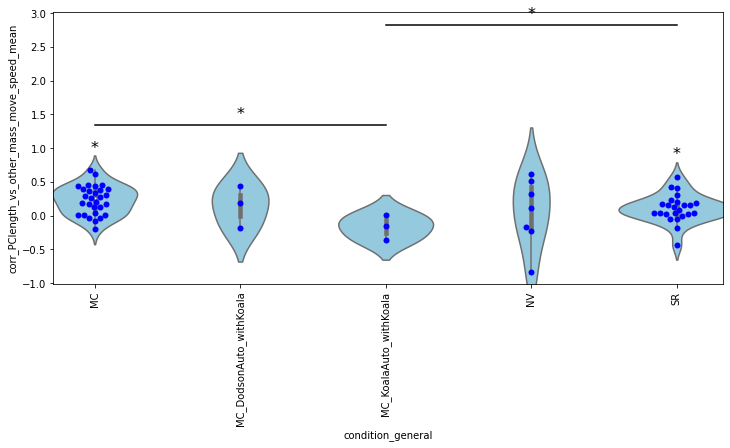

In [169]:
# show all the session-by-session correlation between PC trajectory features and gaze duration 
if 1:    
    import itertools
    
    #####
    # to make the condition more general
    # Define the function for generalizing condition
    def generalize_condition(cond):
        if cond == "MC" or cond.startswith("MC_with"):
            return "MC"
        elif cond == "SR" or cond.startswith("SR_with"):
            return "SR"
        elif cond == "NV" or cond.startswith("NV_with"):
            return "NV"
        else:
            return cond  # default to original condition if no match

    # Apply the function to create the new column
    FRPCAfeatures_gazeduration_corr_all_sessions_df["condition_general"] = \
        FRPCAfeatures_gazeduration_corr_all_sessions_df["condition"].apply(generalize_condition)
    
    #####
    
    if not doNeuroPCA_plot:
        # corr_type = 'corr_otherani_otherlever_dist_meanspeed_vs_gaze_accumulation'
        # corr_type = 'corr_animal_animal_dist_meanspeed_vs_gaze_accumulation'
        # corr_type = 'corr_animal_animal_dist_mean_vs_gaze_accumulation'
        corr_type = 'corr_animal_animal_dist_min_vs_gaze_accumulation'
        # corr_type = 'corr_other_mass_move_speed_mean_vs_gaze_accumulation'
        # corr_type = 'corr_other_mass_move_speed_mean_vs_gaze_accumulation'
    elif doNeuroPCA_plot:
        # corr_type = 'corr_PClength_vs_animal_animal_dist_appoachslope'
        # corr_type = 'corr_PClength_vs_otherani_otherlever_dist_appoachslope'
        # corr_type = 'corr_PClength_vs_otherani_otherlever_dist_meanspeed'
        # corr_type = 'corr_PClength_vs_animal_lever_dist_meanspeed'
        corr_type = 'corr_PClength_vs_other_mass_move_speed_mean'
        # corr_type = 'corr_PClength_vs_num_preceding_failpull'
        # corr_type = 'corr_PClength_vs_time_from_last_reward'    
        
    fig2, axs2 = plt.subplots(1, 1)
    fig2.set_figheight(5)
    fig2.set_figwidth(12)

    # Define a consistent color
    box_color = 'skyblue'

    # Plot boxplot and swarmplot
    seaborn.violinplot(ax=axs2, data=FRPCAfeatures_gazeduration_corr_all_sessions_df,
                x='condition_general', y=corr_type,
                color=box_color)

    seaborn.swarmplot(ax=axs2, data=FRPCAfeatures_gazeduration_corr_all_sessions_df,
                   x='condition_general', y=corr_type,
                   color='b', size=6)

    # Rotate x-axis ticks
    axs2.set_xticklabels(axs2.get_xticklabels(), rotation=90)

    # Significance from 0 (Wilcoxon signed-rank)
    conditions = FRPCAfeatures_gazeduration_corr_all_sessions_df['condition_general'].unique()
    y_max = FRPCAfeatures_gazeduration_corr_all_sessions_df[corr_type].max()
    y_min = FRPCAfeatures_gazeduration_corr_all_sessions_df[corr_type].min()

    y_offset = (y_max - y_min) * 0.15  # vertical spacing for significance bars

    for i, cond in enumerate(conditions):
        data = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition_general'] == cond][corr_type].dropna()
        if len(data) > 0 and np.any(data != 0):  # Wilcoxon requires non-zero variation
            try:
                stat, p = st.wilcoxon(data)
                if p < 0.01:
                    axs2.text(i, data.max() + y_offset, '*', ha='center', va='bottom', fontsize=16, color='black')
            except ValueError:
                pass  # skip if data not suitable for Wilcoxon

    # Pairwise comparisons (Mann–Whitney U)
    pairs = list(itertools.combinations(range(len(conditions)), 2))
    for j, (i1, i2) in enumerate(pairs):
        cond1 = conditions[i1]
        cond2 = conditions[i2]
        data1 = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition_general'] == cond1][corr_type].dropna()
        data2 = FRPCAfeatures_gazeduration_corr_all_sessions_df[
            FRPCAfeatures_gazeduration_corr_all_sessions_df['condition_general'] == cond2][corr_type].dropna()

        if len(data1) > 0 and len(data2) > 0:
            stat, p = st.mannwhitneyu(data1, data2, alternative='two-sided')
            if p < 0.05:
                y = max(data1.max(), data2.max()) + y_offset * (j + 2)
                axs2.plot([i1, i2], [y, y], lw=1.5, c='black')
                axs2.text((i1 + i2) / 2, y + y_offset * 0.2, '*', ha='center', va='bottom', fontsize=16)
     
    # fig2.tight_layout()

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/SelfGaze_PartnerIntention_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
         
        fig2.savefig(figsavefolder+'bhvevents_aligned_continuousBhv_corrSummary_'+bhvname_ana+'_'+
                     pull_trig_gazeprob_name+'_'+pull_trig_events_tgtname+'_'+gaze_duration_type+'_'+
                     corr_type+savefile_sufix+'.pdf')
        

    # to see if there's correlation between correlation coefficient of PC features vs gaze duration, and succ rate 
    from scipy.stats import pearsonr

    # Drop rows where either column is NaN
    subset_df = FRPCAfeatures_gazeduration_corr_all_sessions_df[['condition_general', 'succrate', corr_type]].dropna()

    # Group by condition and calculate Pearson correlation and p-value
    def compute_corr_pval(group):
        if len(group) < 2:
            return pd.Series({'r': None, 'p': None})  # Not enough data to correlate
        r, p = pearsonr(group['succrate'], group[corr_type])
        return pd.Series({'r': r, 'p': p})

    grouped_corrs = subset_df.groupby('condition_general').apply(compute_corr_pval)

    # Display the result
    print(f'Correlation between {corr_type} and succrate:')
    print(grouped_corrs)
        

In [170]:
bhvname_ana

'pull'

### sanity check plot: separating the gaze accumulation intro quantiles, and plot the mean social gaze and partner_lever distance traces

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


TypeError: cannot unpack non-iterable numpy.float64 object

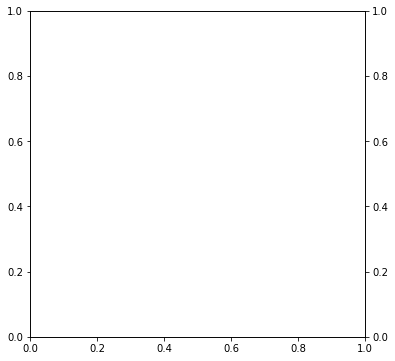

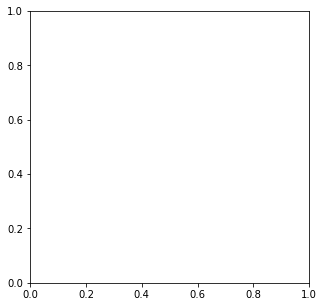

In [171]:
if 1:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax2 = ax.twinx()  # Secondary y-axis
    
    # === Scatter plot of gaze_accum vs partner_face_lever_min ===
    fig2, ax_scatter = plt.subplots(figsize=(5, 5))

    # animal_exmaple = 'dodson'
    # session_example = '20250409'
    # session_example = '20250428_MC'
    
    animal_exmaple = 'kanga'
    # session_example = '20240523'
    session_example = '20240606'
    # session_example = '20240808'
    # session_example = '20240809'
    # session_example = '20240812'
    # session_example = '20250415'
    # session_example = '20250428_MC'

    
    # Filter data
    ind_example = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == session_example
    FRPCAfeatures_example = FRPCAfeatures_all_sessions_allevents_sum_df[ind_example]

    ind_example = FRPCA_all_sessions_allevents_sum_df['session'] == session_example
    FRPCA_example = FRPCA_all_sessions_allevents_sum_df[ind_example]

    if doSingleSelfPulls:
        shared_cols = ['condition', 'session', 'act_animal', 'bhv_name', 'bhv_id']
        FRPCA_example_subset = FRPCA_example.merge(
                                FRPCAfeatures_example[shared_cols].drop_duplicates(),
                                on=shared_cols,
                                how='inner'
                            )
        FRPCA_example = FRPCA_example_subset
        
    # Gaze durations
    gaze_durations = np.array(FRPCAfeatures_example['gaze_accum'])
    q1, q2 = np.nanquantile(gaze_durations, [1/3, 2/3])
    ind_low = gaze_durations <= q1
    ind_mid = (gaze_durations > q1) & (gaze_durations <= q2)
    ind_high = gaze_durations > q2

    time_trace = np.arange(-4, 4, 1/fps)

    colors = ['b', 'r', 'y']
    labels = ['low', 'mid', 'high']
    inds = [ind_low, ind_mid, ind_high]

    for ii in range(3):
        # Social gaze trace (primary y-axis)
        trials_socialgaze = np.stack(FRPCA_example[inds[ii]][pull_trig_gazeprob_name], axis=0)
        mean_trace = np.nanmean(trials_socialgaze, axis=0)
        sem_trace = np.nanstd(trials_socialgaze, axis=0) / np.sqrt(trials_socialgaze.shape[0])

        ax.plot(time_trace, mean_trace, color=colors[ii], linewidth=1.5, alpha=0.5, label=pull_trig_gazeprob_name+f" when {labels[ii]} gaze accumulation ({np.sum(inds[ii])} trials)")
        ax.fill_between(time_trace, mean_trace - sem_trace, mean_trace + sem_trace, color=colors[ii], alpha=0.15)

        # Lever distance trace (secondary y-axis)
        # trials_dist = np.stack(FRPCAfeatures_example[inds[ii]][pull_trig_events_tgtname+'_speed'], axis=0)
        trials_dist = np.stack(FRPCA_example[inds[ii]][pull_trig_events_tgtname], axis=0)
        mean_dist = np.nanmean(trials_dist, axis=0)
        sem_dist = np.nanstd(trials_dist, axis=0) / np.sqrt(trials_dist.shape[0])

        # Thicker, dashed line with markers to highlight
        if 0:
            #
            ax2.plot(time_trace, mean_dist, color=colors[ii], linestyle='-', linewidth=3, marker='o', markersize=4, 
                     label=pull_trig_events_tgtname+f" when {labels[ii]} gaze accumulation ({np.sum(inds[ii])} trials)")
            #
            # ax2.plot(time_trace, mean_dist, color=colors[ii], linestyle='-', linewidth=3, marker='o', markersize=4, 
            #         label=pull_trig_events_tgtname+'_speed'+f" when {labels[ii]} gaze accumulation ({np.sum(inds[ii])} trials)")
            #
            ax2.fill_between(time_trace, mean_dist - sem_dist, mean_dist + sem_dist, color=colors[ii], alpha=0.25)

    # Axis labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Social gaze probability', color='gray')
    if 0:
        ax2.set_ylabel(pull_trig_events_tgtname+'_speed', color='black')
        # ax2.set_ylabel(pull_trig_events_tgtname, color='black')
    ax.set_title(f"{animal_exmaple} - {session_example}")

    # Handle legends (combined from both axes)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left',bbox_to_anchor=(1.15, 1))
    
    
    ## scatter plot
    if not doNeuroPCA_plot:
        xxx_plotname = 'gaze_accum'
        x = FRPCAfeatures_example[xxx_plotname]
        # yyy_plotname = pull_trig_events_tgtname+'_appoachslope'
        # yyy_plotname = pull_trig_events_tgtname+'_meanspeed'
        yyy_plotname = pull_trig_events_tgtname+'_mean'
        # yyy_plotname = pull_trig_events_tgtname+'_max'
        # yyy_plotname = pull_trig_events_tgtname+'_min'
        # yyy_plotname = pull_trig_events_tgtname+'_changetime'
        y = FRPCAfeatures_example[yyy_plotname]
    #
    elif doNeuroPCA_plot:
        # xxx_plotname = pull_trig_events_tgtname+'_appoachslope'
        # xxx_plotname = pull_trig_events_tgtname+'_meanspeed'
        xxx_plotname = pull_trig_events_tgtname+'_mean'
        x = FRPCAfeatures_example[xxx_plotname]
        yyy_plotname = 'PClength'
        y = FRPCAfeatures_example[yyy_plotname]

    # Drop NaNs
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = np.array(x)[valid]
    y_valid = np.array(y)[valid]

    # Compute correlation
    from scipy.stats import pearsonr
    r_val, p_val = pearsonr(x_valid, y_valid)

    # Plot scatter
    ax_scatter.scatter(x_valid, y_valid, color='darkgreen', alpha=0.6, edgecolor='k')

    # Regression line
    slope, intercept = np.polyfit(x_valid, y_valid, 1)
    x_line = np.linspace(np.min(x_valid), np.max(x_valid), 100)
    y_line = slope * x_line + intercept
    ax_scatter.plot(x_line, y_line, color='black', linestyle='--', linewidth=2)

    # Labels and title
    if not doNeuroPCA_plot:
        ax_scatter.set_xlabel('Gaze accumulation (s)')
        ax_scatter.set_ylabel(yyy_plotname)
    elif doNeuroPCA_plot:
        ax_scatter.set_xlabel(xxx_plotname)
        ax_scatter.set_ylabel(yyy_plotname)
    ax_scatter.set_title(f"Correlation: r = {r_val:.2f}, p = {p_val:.3f}")

    # Optional grid
    ax_scatter.grid(True)
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+session_example+'/'

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+'forExample_trace_between_'+pull_trig_gazeprob_name+'_and_'+pull_trig_events_tgtname+'.pdf')
        #
        fig2.savefig(figsavefolder+'forExample_scatter_between_'+xxx_plotname+'_and_'+yyy_plotname+'.pdf')
    

In [ ]:
trials_socialgaze = np.stack(FRPCA_example[pull_trig_gazeprob_name], axis=0)
mean_trace = np.nanmean(trials_socialgaze, axis=0)
sem_trace = np.nanstd(trials_socialgaze, axis=0) / np.sqrt(trials_socialgaze.shape[0])
plt.plot(time_trace, mean_trace)

In [ ]:
# show the single trial trajectories of an example session - compared the gaze_pull separating three quantile based on the gaze duration
if 1:
    # Create a 3D figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # animal_exmaple = 'dodson'
    # session_example = '20250409'
    # session_example = '20250428_MC'
    
    animal_exmaple = 'kanga'
    # session_example = '20240523'
    session_example = '20240606'
    # session_example = '20240808'
    # session_example = '20240809'
    # session_example = '20240812'
    # session_example = '20250415'
    # session_example = '20250428_MC'


    ind_example = FRPCAfeatures_all_sessions_allevents_sum_df['session'] == session_example
    FRPCAfeatures_example = FRPCAfeatures_all_sessions_allevents_sum_df[ind_example]
    #
    ind_example = FRPCA_all_sessions_allevents_sum_df['session']==session_example
    FRPCA_example = FRPCA_all_sessions_allevents_sum_df[ind_example]
    
    if doSingleSelfPulls:
        shared_cols = ['condition', 'session', 'act_animal', 'bhv_name', 'bhv_id']
        FRPCA_example_subset = FRPCA_example.merge(
                                FRPCAfeatures_example[shared_cols].drop_duplicates(),
                                on=shared_cols,
                                how='inner'
                            )
        FRPCA_example = FRPCA_example_subset
        
    #
    # xxx_type = 'gaze_accum'
    # xxx_type = 'animal_animal_dist_appoachslope'
    # xxx_type = 'otherani_otherlever_dist_appoachslope'
    # xxx_type = 'otherani_otherlever_dist_meanspeed'
    xxx_type = 'other_mass_move_speed_mean'

    #
    # gaze_durations = FRPCAfeatures_example['gazestop_time'] - FRPCAfeatures_example['gazestart_time']
    gaze_durations = FRPCAfeatures_example[xxx_type]
    gaze_durations = np.array(gaze_durations)
    #
    # Compute tertile (33rd and 67th percentiles), ignoring NaNs
    q1, q2 = np.nanquantile(gaze_durations, [1/3, 2/3])
    #
    # Separate data into three groups
    ind_low = gaze_durations <= q1
    ind_mid = (gaze_durations > q1) & (gaze_durations <= q2)
    ind_high = gaze_durations > q2
    
    for ii in np.arange(0,3,1):
        if ii == 0:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_low]['PCs'], axis=0),axis=0)
            traj_clr = 'b'
            traj_lab = 'low '+xxx_type+' ' + str(np.sum(ind_low))+' trials'
        elif ii == 1:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_mid]['PCs'], axis=0),axis=0)
            traj_clr = 'r'
            traj_lab = 'mid '+xxx_type+' ' + str(np.sum(ind_mid))+' trials'
        elif ii == 2:
            meanPCA_traj = np.nanmean(np.stack(FRPCA_example[ind_high]['PCs'], axis=0),axis=0)
            traj_clr = 'y'
            traj_lab = 'high '+xxx_type+' ' + str(np.sum(ind_high))+' trials'
           
        ntimepoints = np.shape(meanPCA_traj)[0]
        
        xxx = gaussian_filter1d(meanPCA_traj[:,0],6)
        yyy = gaussian_filter1d(meanPCA_traj[:,1],6)
        zzz = gaussian_filter1d(meanPCA_traj[:,2],6)
        if gaze_duration_type == 'before_pull':
            xxx = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),0],3)
            yyy = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),1],3)
            zzz = gaussian_filter1d(meanPCA_traj[:int(ntimepoints/2),2],3)   
        elif gaze_duration_type == 'after_pull':
            xxx = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,0],3)
            yyy = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,1],3)
            zzz = gaussian_filter1d(meanPCA_traj[int(ntimepoints/2):,2],3)   
            
        ax.plot3D(xxx, yyy, zzz, color=traj_clr, linewidth=2, label=traj_lab)
        ax.plot3D(xxx[0], yyy[0], zzz[0], color=traj_clr, marker ='o',markersize = 12)
        ax.plot3D(xxx[-1], yyy[-1], zzz[-1], color=traj_clr, marker ='s',markersize = 12)

    
    ax.legend()
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+'/'+session_example+'/'

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+'forExample_PCAtrajectory_in_'+xxx_type+'_quantiles.pdf')

    
    
    

## analysis with 'trial pooling' across sessions from the same condition
### pool sessions for each task conditions together and then run PCA
#### pool sessions based on quantiles of gaze-accumulation or gaze-length variables or partner-intention related variables  (e.g. 5 quantiles)

In [173]:
# only analyze a subset of conditions
# act_animals_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['act_animal'])
# act_animals_to_ana = ['kanga']
act_animals_to_ana = ['dodson']
nanimal_to_ana = np.shape(act_animals_to_ana)[0]
#
# bhv_names_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'])
bhv_names_to_ana = ['pull']
# bhv_names_to_ana = ['failpull']
# bhv_names_to_ana = ['succpull']
# bhv_names_to_ana = ['succpull','failpull']
nbhvnames_to_ana = np.shape(bhv_names_to_ana)[0]
bhvname_clrs = ['r','y','g','b','c','m','#458B74','#FFC710','#FF1493','#A9A9A9','#8B4513']
#
# # the following analysis can only do one conditions 
# # multiple condition will be considered into one conditions for quantile and FR averaging analysis
# conditions_to_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['condition'])
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['MC','SR',]
###
# For Kanga
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVermelho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV','NV_withDodson'] # NV
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 
#                      'SR', 'SR_withDodson',]
###
# For Dodson
conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['MC', 'MC_withKanga', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL
# conditions_to_ana = ['NV_withKanga'] # NV
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 
#                      'SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ]

cond_toplot_type = 'allMC'

nconds_to_ana = np.shape(conditions_to_ana)[0]

doOnlySigniNeurons = 0 # define the significant neurons using the previous code

# newly added control!!
# only look at pull aligned events that has no preceding self pull 
doSingleSelfPulls = 0

# only look at pull aligned events that do not have juice deliever effect from the previous pull
doFarLastRewards = 0

# only look at pulls that has large reaction time
doLargeRTpulls = 0
largeRTthreshold = 2 # the threshold for defining large threahold

In [174]:
pull_trig_events_tgtname

'other_mass_move_speed'

In [175]:
import numpy as np
import pandas as pd
import scipy.signal

if 1:
    # load and prepare the data
    bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.DataFrame(columns=['condition', 'session', 'act_animal',
                                                                                 'bhv_name', 'bhv_id', 'FR_ievent',
                                                                                 'clusterID', 'channelID',
                                                                                pull_trig_events_tgtname+'_mean_ievent',
                                                                                pull_trig_events_tgtname+'_meanspeed_ievent',
                                                                                pull_trig_events_tgtname+'_meanvelocity_ievent',
                                                                                pull_trig_events_tgtname+'_max_ievent',
                                                                                pull_trig_events_tgtname+'_min_ievent',
                                                                                pull_trig_events_tgtname+'_changetime_ievent',
                                                                                pull_trig_events_tgtname+'_appoachslope_ievent',
                                                                                 ])
    #
    bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = pd.DataFrame()

    # step 1 for the bhvevents_aligned_FR_allevents_all_dates_df, get and gaze-related variables and calculate features

    # it's better to match this variable with the previous one
    # add three kinds of gaze duration definition (around pull, before pull, after pull)
    # gaze_duration_type = 'before_pull'  # 'around_pull', 'before_pull', 'after_pull'
    gaze_duration_type = 'after_pull'  # 'around_pull', 'before_pull', 'after_pull'
    # xxx_type = pull_trig_events_tgtname+'_appoachslope'
    # xxx_type = pull_trig_events_tgtname+'_meanspeed'
    xxx_type = pull_trig_events_tgtname+'_mean'
    # xxx_type = pull_num_pre_failpull_name
    # xxx_type = pull_time_pre_reward_name
    
    # special here, number of quantile to use for pooling across different days
    num_quantiles = 3 # 10

    #
    for icond_ana in np.arange(0, nconds_to_ana, 1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_allevents_all_dates_df['condition'] == cond_ana

        for ianimal_ana in np.arange(0, nanimal_to_ana, 1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_allevents_all_dates_df['act_animal'] == act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond]['dates'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0, ndates_ana, 1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_allevents_all_dates_df['dates'] == date_ana

                # get the neurons
                neurons_ana = np.unique(
                    bhvevents_aligned_FR_allevents_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                for ineuron in np.arange(0, nneurons, 1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_allevents_all_dates_df['clusterID'] == clusterID_ineuron

                    for ibhvname_ana in np.arange(0, nbhvnames_to_ana, 1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_allevents_all_dates_df['bhv_name'] == bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date

                        bhvevents_aligned_FR_allevents_tgt = bhvevents_aligned_FR_allevents_all_dates_df[
                            ind_ana].copy()  # Use .copy() to avoid SettingWithCopyWarning

                        if not bhvevents_aligned_FR_allevents_tgt.empty:
                            channelID = bhvevents_aligned_FR_allevents_tgt['channelID'].iloc[0]

                            #
                            # load and plot bhv event ('pull') aligned FR
                            FRs_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt['FR_allevents'].iloc[0])
                            nevents_FR = np.shape(FRs_allevents_ineuron)[1]

                            #
                            # load and plot the pull aligned continuous bhv variables
                            conBhv_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_trig_events_tgtname].iloc[0])
                            conBhv_allevents_ineuron = np.array(conBhv_allevents_ineuron)
                            conBhv_allevents_ineuron = conBhv_allevents_ineuron.transpose()
                            #
                            nevents_bhv = np.shape(conBhv_allevents_ineuron)[1]
                            
                            #
                            # load the self pull variables
                            selfpull_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_trig_selfpull_name].iloc[0])
                            selfpull_allevents_ineuron = np.array(selfpull_allevents_ineuron)
                            selfpull_allevents_ineuron = selfpull_allevents_ineuron.transpose()
                            
                            # 
                            # load the pull reaction time information
                            pull_rt_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_rt_name].iloc[0])
                            
                            # load the prefailpull number and time since the last reward
                            prefailpullnum_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_num_pre_failpull_name].iloc[0])
                            prefailpullnum_allevents_ineuron = np.array(prefailpullnum_allevents_ineuron)
                            #
                            lastrewardtime_allevents_ineuron = np.array(
                                bhvevents_aligned_FR_allevents_tgt[pull_time_pre_reward_name].iloc[0])
                            lastrewardtime_allevents_ineuron = np.array(lastrewardtime_allevents_ineuron)
                            
                            # if the pull aligned FR and bhv have different number
                            if not nevents_FR == nevents_bhv:
                                # print(date_ana+' mismatched number')
                                if nevents_FR < nevents_bhv:
                                    conBhv_allevents_ineuron = conBhv_allevents_ineuron[:, 0:nevents_FR]
                                else:
                                    FRs_allevents_ineuron = FRs_allevents_ineuron[:, 0:nevents_bhv]

                            #
                            nevents = np.min([nevents_FR, nevents_bhv])

                            # get each bhv events
                            for bhv_id in np.arange(0, nevents, 1):
                                FRs_ievent_ineuron = FRs_allevents_ineuron[:, bhv_id]
                                conBhv_ievent_ineuron = conBhv_allevents_ineuron[:, bhv_id]
                                selfpull_ievent_ineuron = selfpull_allevents_ineuron[:, bhv_id]
                                
                                pull_rt_ievent_ineuron = pull_rt_allevents_ineuron[bhv_id]

                                # load the prefailpull number and time since the last reward
                                prefailpullnum_ievent_ineuron = prefailpullnum_allevents_ineuron[bhv_id]
                                lastrewardtime_ievent_ineuron = lastrewardtime_allevents_ineuron[bhv_id]
                                
                                #
                                # count self pull after self pull onset, 
                                # the idea is to make sure the effect is not becuase of the pull action
                                from scipy.signal import find_peaks
                                #
                                x_full = np.arange(-4,4,1/fps)
                                post_mask = x_full>0.15
                                try:
                                    # selfpull_num = np.trapz(pull_trig_selfpull_ievent[pre_mask], dx=dt)
                                    data = selfpull_ievent_ineuron[post_mask]
                                    peaks, _ = find_peaks(data)
                                    selfpull_num = len(peaks)
                                except:
                                    selfpull_num = np.nan
                                    
                                    
                                #
                                # analyze the pull triggered behavioral events
                                #
                                x_full = np.arange(-4, 4, 1/fps)
                                #
                                if gaze_duration_type == 'before_pull':
                                    # Only use the pre-pull window (-4s to 0s)
                                    pre_mask = x_full <= 0
                                    # pre_mask = (x_full <= 0) & (x_full >= -2) # manipulate the size of the time window
                                elif gaze_duration_type == 'after_pull':
                                    # Only use the post-pull window (0s to 4s)
                                    pre_mask = x_full >= 0
                                elif gaze_duration_type == 'around_pull':
                                    # the entire -4 to 4s
                                    pre_mask = (x_full <= 0)|(x_full >= 0) 

                                #
                                partner_face_lever_mean = np.nanmean(conBhv_ievent_ineuron[pre_mask])
                                
                                if (pull_trig_events_tgtname == 'otherani_otherlever_dist') | \
                                   (pull_trig_events_tgtname == 'animal_lever_dist') | \
                                   (pull_trig_events_tgtname == 'otherani_othertube_dist') | \
                                   (pull_trig_events_tgtname == 'animal_tube_dist') | \
                                   (pull_trig_events_tgtname == 'animal_animal_dist'):

                                    partner_face_lever_velocity = np.gradient(conBhv_ievent_ineuron, 1/fps)
                                    #
                                    partner_face_lever_speed = np.abs(partner_face_lever_velocity)
                                    #
                                    partner_face_lever_meanvelocity = np.nanmean(partner_face_lever_velocity[pre_mask])
                                    #
                                    partner_face_lever_meanspeed = np.nanmean(partner_face_lever_speed[pre_mask])

                                    min_dist = np.arange(-4,4,1/fps)[np.argmin(conBhv_ievent_ineuron)]
                                    max_dist = np.arange(-4,4,1/fps)[np.argmax(conBhv_ievent_ineuron)]
                                    #
                                    pre_min_mask = x_full <= min_dist

                                    # find the time that the dramatic change starts, if could not find it, use the -4s
                                    percentile = 95
                                    dt = 1 / fps
                                    abs_derivative = np.abs(np.gradient(conBhv_ievent_ineuron[x_full <= 0], dt))
                                    threshold = np.percentile(abs_derivative, percentile)
                                    # Start from the first time point (index 0)
                                    idx_change = np.where(abs_derivative > threshold)[0]
                                    if len(idx_change) > 0:
                                        onset_idx = idx_change[0]
                                        change_time = x_full[x_full <= 0][onset_idx]
                                    else:
                                        change_time = x_full[0]
                                    #
                                    partner_face_lever_changetime = change_time
                                    #
                                    post_changetime_mask = x_full >= change_time
                                    #
                                    # min and max after the change_time
                                    min_dist_post_changetime = x_full[x_full>=change_time][np.argmin(conBhv_ievent_ineuron[x_full>=change_time])]
                                    max_dist_post_changetime = x_full[x_full>=change_time][np.argmax(conBhv_ievent_ineuron[x_full>=change_time])]

                                    #
                                    # find the partner lever approaching trend
                                    from scipy.stats import linregress
                                    # Define time range and extract window
                                    y_full = np.array(conBhv_ievent_ineuron)                      
                                    #
                                    # x_pre = x_full[pre_mask]
                                    # y_pre = y_full[pre_mask]
                                    # x_pre = x_full[pre_min_mask]
                                    # y_pre = y_full[pre_min_mask]
                                    # x_pre = x_full[pre_min_mask & post_changetime_mask]
                                    # y_pre = y_full[pre_min_mask & post_changetime_mask]    
                                    x_pre = x_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]
                                    y_pre = y_full[post_changetime_mask & (x_full<=min_dist_post_changetime)]                        
                                    # Linear regression
                                    # slope, intercept, r_value, p_value, std_err = linregress(x_pre, y_pre)
                                    slope = (y_pre[-1] - y_pre[0])/(x_pre[-1] - x_pre[0])
                                    #
                                    approaching_slope = slope

                                else:
                                    partner_face_lever_velocity = np.ones(np.shape(np.arange(-4,4,1/fps)))*np.nan
                                    #
                                    partner_face_lever_speed = np.ones(np.shape(np.arange(-4,4,1/fps)))*np.nan

                                    partner_face_lever_meanspeed = np.nan

                                    min_dist = np.nan
                                    max_dist = np.nan

                                    approaching_slope = np.nan

                                    partner_face_lever_changetime = np.nan
                                
                                #
                                bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.concat(
                                    [bhvevents_aligned_FR_and_eventFeatures_all_dates_df, pd.DataFrame({
                                        'condition': [cond_ana],
                                        'act_animal': [act_animal_ana],
                                        'bhv_name': [bhvname_ana],
                                        'session': [date_ana],
                                        'bhv_id': [bhv_id],
                                        'clusterID': [clusterID_ineuron],
                                        'channelID': [channelID],
                                        'FR_ievent': [FRs_ievent_ineuron],
                                        'selfpull_num_ievent': [selfpull_num],
                                        'pull_rt_ievent':[pull_rt_ievent_ineuron],
                                        pull_trig_events_tgtname:[conBhv_ievent_ineuron],
                                        pull_trig_events_tgtname+'_mean_ievent':[partner_face_lever_mean],
                                        pull_trig_events_tgtname+'_speed_ievent':[partner_face_lever_speed],
                                        pull_trig_events_tgtname+'_meanspeed_ievent':[partner_face_lever_meanspeed],
                                        pull_trig_events_tgtname+'_velocity_ievent':[partner_face_lever_velocity],
                                        pull_trig_events_tgtname+'_meanvelocity_ievent':[partner_face_lever_meanvelocity],
                                        pull_trig_events_tgtname+'_max_ievent':[max_dist],
                                        pull_trig_events_tgtname+'_min_ievent':[min_dist],
                                        pull_trig_events_tgtname+'_changetime_ievent':[partner_face_lever_changetime],
                                        pull_trig_events_tgtname+'_appoachslope_ievent':[approaching_slope],
                                        pull_num_pre_failpull_name+'_ievent':prefailpullnum_ievent_ineuron,
                                        pull_time_pre_reward_name+'_ievent':lastrewardtime_ievent_ineuron,
                                    })], ignore_index=True)

                                
    # only look at the pulls that has no pull preceeding
    if doSingleSelfPulls:
        ind_good = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['selfpull_num_ievent']==0
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_good]
                                
    #
    # remove events that still has the effect from previous juice
    if doFarLastRewards:
        # reward should be beyond the -4s time window we are looking at, and also consider the reward effect last ~1s
        ind_good = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['lastreward_time_ievent']<=(-4-1)
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_good]
                    
    #
    # only consider pulls that has large reaction time
    if doLargeRTpulls:
        # reward should be beyond the -4s time window we are looking at, and also consider the reward effect last ~1s
        ind_good = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['pull_rt_ievent']>=largeRTthreshold
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_good]
                   
    #
    # remove trial without gaze_accum
    # ind_nan = np.isnan(bhvevents_aligned_FR_and_eventFeatures_all_dates_df['gaze_accum_ievent'])
    # bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[~ind_nan]
         
    
    # add the quantile information using the all sessions' data
    # consider each date separately

    # Create a list to store the DataFrames for each date
    all_dates_dfs = []

    # Get unique dates
    unique_dates = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'].unique()

    for date_ana in unique_dates:
        date_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
            bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'] == date_ana].copy()

        # separating quantiles
        quantile_tgt = date_df[xxx_type+'_ievent'].dropna()  # Handle potential NaNs
        n_unique = len(quantile_tgt.unique())
        n_bins = min(num_quantiles, n_unique - 1)  # Calculate the maximum possible bins
        if n_bins > 1:  # Only proceed if we can make at least 2 bins
            try:
                quantile_bins = np.nanquantile(quantile_tgt, np.linspace(0, 1, num_quantiles + 1))
                date_df[xxx_type+'_quantile'] = pd.cut(
                    date_df[xxx_type+'_ievent'],
                    bins=quantile_bins,
                    labels=False,
                    include_lowest=True,
                    duplicates='drop'  # Drop duplicate bin edges
                )
                quantile_col = xxx_type+'_quantile'
                title_prefix = xxx_type
            except ValueError as e:
                print(f"Warning: Error calculating quantiles on date {date_ana}: {e}")
                date_df[xxx_type+'_quantile'] = np.nan
                quantile_col = xxx_type+'_quantile'
                title_prefix = xxx_type
        else:
            date_df[xxx_type+'_quantile'] = np.nan
            quantile_col = xxx_type+'_quantile'
            title_prefix = xxx_type
            print(f"Warning: Not enough distinct data for quantiles on date {date_ana}")


        all_dates_dfs.append(date_df)

    # Concatenate the DataFrames back together
    bhvevents_aligned_FR_and_eventFeatures_all_dates_df = pd.concat(all_dates_dfs, ignore_index=True)

    # average for each neuron the firing rate of each quantile
    if 'quantile_col' in locals():
        # Iterate through unique (clusterID, session) pairs
        for (cluster_id, session_id) in bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
            ['clusterID', 'session']].drop_duplicates().itertuples(index=False):
            neuron_session_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
                (bhvevents_aligned_FR_and_eventFeatures_all_dates_df['clusterID'] == cluster_id) &
                (bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'] == session_id)
            ].copy()

            for q_val in neuron_session_df[quantile_col].dropna().unique():
                quantile_df = neuron_session_df[neuron_session_df[quantile_col] == q_val]
                if not quantile_df.empty:
                    all_fr_traces = np.vstack(quantile_df['FR_ievent'].tolist())
                    mean_fr_trace = np.nanmean(all_fr_traces, axis=0)

                    # Get representative metadata
                    condition = quantile_df['condition'].iloc[0]
                    act_animal = quantile_df['act_animal'].iloc[0]
                    bhv_name = quantile_df['bhv_name'].iloc[0]
                    channelID = quantile_df['channelID'].iloc[0]

                    new_row = {
                        'condition': condition,
                        'session': session_id,
                        'act_animal': act_animal,
                        'bhv_name': bhv_name,
                        'clusterID': cluster_id,
                        'channelID': channelID,
                        quantile_col: int(q_val),
                        'mean_FR_trace': mean_fr_trace
                    }
                    bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = pd.concat(
                        [bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df,
                         pd.DataFrame([new_row])],
                        ignore_index=True
                    )

/tmp/ipykernel_4052140/2364132019.py:166: RuntimeWarning: Mean of empty slice
  partner_face_lever_mean = np.nanmean(conBhv_ievent_ineuron[pre_mask])


In [176]:
bhvevents_aligned_FR_and_eventFeatures_all_dates_df.keys()

Index(['condition', 'session', 'act_animal', 'bhv_name', 'bhv_id', 'FR_ievent',
       'clusterID', 'channelID', 'other_mass_move_speed_mean_ievent',
       'other_mass_move_speed_meanspeed_ievent',
       'other_mass_move_speed_meanvelocity_ievent',
       'other_mass_move_speed_max_ievent', 'other_mass_move_speed_min_ievent',
       'other_mass_move_speed_changetime_ievent',
       'other_mass_move_speed_appoachslope_ievent', 'selfpull_num_ievent',
       'pull_rt_ievent', 'other_mass_move_speed',
       'other_mass_move_speed_speed_ievent',
       'other_mass_move_speed_velocity_ievent',
       'num_preceding_failpull_ievent', 'time_from_last_reward_ievent',
       'other_mass_move_speed_mean_quantile'],
      dtype='object')

In [177]:
bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df.keys()

Index(['condition', 'session', 'act_animal', 'bhv_name', 'clusterID',
       'channelID', 'other_mass_move_speed_mean_quantile', 'mean_FR_trace'],
      dtype='object')

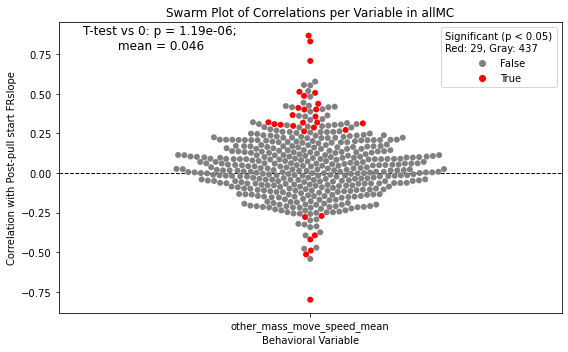

In [187]:
## It's for defining slope ramping feature for each neurons, and regress over the gaze accumulation or other variables
if 1:    
    #
    bhveventsFeatures_and_FRslopes_all_dates_df = pd.DataFrame(columns=['condition', 'session', 'act_animal',
                                                                         'bhv_name', 'clusterID', 'channelID',                                                                   
                                                                                 ])
    
    # xvar_name = 'gaze_accum' # or 'gaze_accum', 'gaze_start', 'gaze_stop', 'selfpull_num','pull_rt'
    # xvar_name = 'pull_rt' # or 'gaze_accum', 'gaze_start', 'gaze_stop', 'selfpull_num','pull_rt'
    xvar_name = 'other_mass_move_speed_mean'
    
    for icond_ana in np.arange(0, nconds_to_ana, 1):
        cond_ana = conditions_to_ana[icond_ana]
        ind_cond = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['condition'] == cond_ana

        for ianimal_ana in np.arange(0, nanimal_to_ana, 1):
            act_animal_ana = act_animals_to_ana[ianimal_ana]
            ind_animal = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['act_animal'] == act_animal_ana

            # get the dates
            dates_ana = np.unique(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_animal & ind_cond]['session'])
            ndates_ana = np.shape(dates_ana)[0]

            for idate_ana in np.arange(0, ndates_ana, 1):
                date_ana = dates_ana[idate_ana]
                ind_date = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session'] == date_ana

                # get the neurons
                neurons_ana = np.unique(
                    bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_animal & ind_cond & ind_date]['clusterID'])
                nneurons = np.shape(neurons_ana)[0]

                for ineuron in np.arange(0, nneurons, 1):
                    clusterID_ineuron = neurons_ana[ineuron]
                    ind_neuron = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['clusterID'] == clusterID_ineuron

                    for ibhvname_ana in np.arange(0, nbhvnames_to_ana, 1):
                        bhvname_ana = bhv_names_to_ana[ibhvname_ana]
                        ind_bhv = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['bhv_name'] == bhvname_ana

                        ind_ana = ind_animal & ind_bhv & ind_cond & ind_neuron & ind_date

                        bhvevents_aligned_FR_and_eventFeatures_allevents_tgt = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[
                            ind_ana].copy() 

                        channelID_ineuron = bhvevents_aligned_FR_and_eventFeatures_allevents_tgt['channelID'].iloc[0]
                        
                        min_pull_rt = np.nanmin(bhvevents_aligned_FR_and_eventFeatures_allevents_tgt['pull_rt_ievent'])
                        
                        #
                        # calculate the ramping slope and other FR related features
                        # get the firing rate
                        xxx = np.array(list(bhvevents_aligned_FR_and_eventFeatures_allevents_tgt['FR_ievent']))

                        # Time vector: from -4s to 4s (e.g., 240 points for 30Hz)
                        time_vector = np.arange(-4,4,1/fps)

                        # Step 1: Compute average firing rate and find time of max abs deviation after 0s
                        mean_fr = np.nanmean(xxx, axis=0)
                        post_mean_fr = mean_fr[time_vector>-0.15]

                        # Find index of max absolute deviation from baseline (i.e., strongest ramp up or down)
                        baseline = np.nanmean(mean_fr)  # optional: use entire -4 to 0s as baseline
                        abs_dev = np.abs(mean_fr - baseline)
                        peak_idx = np.argmax(abs_dev)
                        #
                        abs_dev = np.abs(post_mean_fr - baseline)
                        postpull_peak_idx = np.argmax(abs_dev)+int(0.0*30)

                        # Get corresponding index in the full time vector
                        peak_time = time_vector[peak_idx]
                        #
                        postpull_peak_time = time_vector[time_vector>-0.15][postpull_peak_idx]

                        
                        # Step 2: Compute slope from 0s to peak_time or 4s for each trial
                        #         in addition, get the firing rate at the peak time
                        slopes = []
                        # flexible end time or fixed end time?
                        dofixedendtime = 1
                        #
                        slope_start_ts = np.where(time_vector>=-0.15)[0][0] # when the time point is -0.15s
                        #
                        for trial_fr in xxx:
                            # 
                            if not dofixedendtime:
                                if peak_time > -0.15:
                                    x = time_vector[slope_start_ts:peak_idx + 1]  # from 0s to peak_time
                                    y = trial_fr[slope_start_ts:peak_idx + 1]
                                else:
                                    # zero_idx = np.where(time_vector>=0)[0][0]
                                    # x = time_vector[:zero_idx]  # from -4s to 0
                                    # y = trial_fr[:zero_idx]
                                    x = time_vector[slope_start_ts:slope_start_ts+postpull_peak_idx + 1]  # from 0s to peak_time
                                    y = trial_fr[slope_start_ts:slope_start_ts+postpull_peak_idx + 1]
                            #
                            elif dofixedendtime:
                                slope_end_ts = np.where(time_vector>=min_pull_rt)[0][0]
                                
                                x = time_vector[slope_start_ts:slope_end_ts]  # from 0s to the peak time 4s
                                y = trial_fr[slope_start_ts:slope_end_ts]
                            #
                            slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
                            slopes.append(slope)
                        #
                        slopes = np.array(slopes)  
                        #
                        # if the neuron fr is ramping down overall, flip the slopes
                        if np.nanmean(slopes)<0:
                            slopes = -slopes
                            
                        #
                        if not dofixedendtime:
                            if peak_time > -0.15:
                                peakFRs = xxx[:,peak_idx]
                            else:
                                # zero_idx = np.where(time_vector>=0)[0][0]
                                # peakFRs = xxx[:,zero_idx]
                                peakFRs = xxx[:,slope_start_ts+postpull_peak_idx]
                        # 
                        elif dofixedendtime:
                            # peakFRs = xxx[:,-1]
                            peakFRs = xxx[:,slope_end_ts]
    
                        # 
                        # get the gaze_accumulation or other variables 
                        xvar = np.array(list(bhvevents_aligned_FR_and_eventFeatures_allevents_tgt[xvar_name+'_ievent']))
                        
                        # get the nan index and remove then in the correlation
                        ind_nan_slopes = np.isnan(slopes)
                        ind_nan_peakFRs  = np.isnan(peakFRs)
                        ind_nan_xvar = np.isnan(xvar)
                        #
                        ind_nan = ind_nan_slopes | ind_nan_peakFRs | ind_nan_xvar
                        
                        # 
                        # regression between FR slopes and xvar (e.g. gaze accumulation)
                        slope2, intercept2, r_value2, p_value2, std_err2 = st.linregress(xvar[~ind_nan], slopes[~ind_nan])
                        #
                        if (r_value2 > 0.99) | (r_value2 < -0.99):
                            r_value2 = np.nan
                            p_value2 = np.nan
                            
                        #
                        # correlation between the peak FR and xvar (e.g. gaze accumulation)
                        slope3, intercept3, r_value3, p_value3, std_err3 = st.linregress(xvar[~ind_nan], peakFRs[~ind_nan])
                        #
                        if (r_value3 > 0.99) | (r_value3 < -0.99):
                            r_value3 = np.nan
                            p_value3 = np.nan
                        
                        # put the data together
                        bhveventsFeatures_and_FRslopes_all_dates_df = pd.concat(
                                    [bhveventsFeatures_and_FRslopes_all_dates_df, pd.DataFrame({
                                        'condition': [cond_ana],
                                        'act_animal': [act_animal_ana],
                                        'bhv_name': [bhvname_ana],
                                        'session': [date_ana],
                                        'clusterID': [clusterID_ineuron],
                                        'channelID': [channelID_ineuron],
                                        'FRpeaktime': [peak_time],
                                        'FRpeaktime_postpull': [postpull_peak_time],
                                        'xvar_name': [xvar_name],
                                        'corr_postpull_FRslope_and_xvar':[r_value2],
                                        'pcorr_postpull_FRslope_and_xvar':[p_value2],
                                        'corr_postpull_peakFR_and_xvar':[r_value3],
                                        'pcorr_postpull_peakFR_and_xvar':[p_value3],
                                    })], ignore_index=True)
                        

    # do some plotting
    yvar_toplot_name = 'FRslope' # FRslope, peakFR
    
    #
    # Assuming df is already your DataFrame:
    df = bhveventsFeatures_and_FRslopes_all_dates_df.copy()

    # Define significance
    df['significance'] = df['pcorr_postpull_'+yvar_toplot_name+'_and_xvar'] < 0.05

    # Drop NaNs in correlation column before analysis
    df_clean = df.dropna(subset=['corr_postpull_'+yvar_toplot_name+'_and_xvar'])

    # Define significance
    df_clean['significance'] = df_clean['pcorr_postpull_'+yvar_toplot_name+'_and_xvar'] < 0.05

    # Count neurons
    n_sig = df_clean['significance'].sum()
    n_nonsig = len(df_clean) - n_sig

    # T-test against 0 (only on non-NaN correlations)
    t_stat, t_pval = st.ttest_1samp(df_clean['corr_postpull_'+yvar_toplot_name+'_and_xvar'], 0)
    meanvalue = np.nanmean(df_clean['corr_postpull_'+yvar_toplot_name+'_and_xvar'])

    # Plot
    figgg = plt.figure(figsize=(8, 5))
    seaborn.swarmplot(
        x='xvar_name',
        y='corr_postpull_'+yvar_toplot_name+'_and_xvar',
        data=df_clean,
        hue='significance',
        palette={True: 'red', False: 'gray'},
        size=6
    )

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.ylabel("Correlation with Post-pull start "+yvar_toplot_name)
    plt.xlabel("Behavioral Variable")
    plt.title("Swarm Plot of Correlations per Variable in "+cond_toplot_type)

    # Custom legend with counts
    plt.legend(
        title=f'Significant (p < 0.05)\nRed: {n_sig}, Gray: {n_nonsig}',
        # labels=['False', 'True'],  # must match unique values in significance
        loc='best'
    )

    # Show t-test result
    plt.text(-0.3, np.nanmax(df['corr_postpull_'+yvar_toplot_name+'_and_xvar']) * 0.9,
             f'T-test vs 0: p = {t_pval:.3g};\n mean = {meanvalue:.2g}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FR_and_gaze_quantile_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        figgg.savefig(figsavefolder+'bhvevents_aligned_'+yvar_toplot_name+'_and_'+xvar_name+'_correlation_'+bhvname_ana+'_'+
                 pull_trig_events_tgtname+'_'+gaze_duration_type+'onset_'+savefile_sufix+'.pdf')
        
                        

In [180]:
##
# do some big picture plot; here is to have a sense of the gaze-accumulation distribution of succ and failed pull
# ...if the setting is set for that
## 
if 0:
    from scipy.stats import ks_2samp

    # to make the condition more general
    # Define the function for generalizing condition
    def generalize_condition(cond):
        if cond == "MC" or cond.startswith("MC_with"):
            return "MC"
        elif cond == "SR" or cond.startswith("SR_with"):
            return "SR"
        else:
            return cond  # default to original condition if no match

    # Apply the function to create the new column
    bhvevents_aligned_FR_and_eventFeatures_all_dates_df["condition_general"] = \
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df["condition"].apply(generalize_condition)
    
    
    # 
    plt.figure(figsize=(20,6))
    data_toplot = bhvevents_aligned_FR_and_eventFeatures_all_dates_df
    # seaborn.kdeplot(data=data_toplot,x='gaze_accum_ievent',hue='bhv_name')
    seaborn.kdeplot(data=data_toplot,x=xxx_type+'_ievent',hue='condition_general',
                   common_norm=False)  # don't normalize across groups
    # seaborn.histplot(data=data_toplot,x='gaze_accum_ievent',hue='bhv_name')

    # Compute group-wise quantiles (deciles from 10% to 90%)
    # quantiles_df = data_toplot.groupby('bhv_name')['gaze_accum_ievent'].quantile(np.linspace(0.1, 0.9, 9)).reset_index()
    quantiles_df = data_toplot.groupby('condition_general')[xxx_type+'_ievent'].quantile(np.linspace(0.1, 0.9, 9)).reset_index()
    quantiles_df.rename(columns={xxx_type+'_ievent': 'quantile_value'}, inplace=True)

    # Draw vertical lines for each quantile
    if 0:
        # palette = dict(zip(data_toplot['bhv_name'].unique(), seaborn.color_palette()))  # color matching seaborn
        palette = dict(zip(data_toplot['condition_general'].unique(), seaborn.color_palette()))  # color matching seaborn

        for _, row in quantiles_df.iterrows():
            plt.axvline(
                row['quantile_value'],
                # color=palette[row['bhv_name']],
                color=palette[row['condition_general']],
                linestyle='--',
                alpha=1
            )

    plt.title('KDE Plot with Quantile Lines')
    plt.show()
    
    # KS test: compare MC vs SR
    if 0:
        group_MC = data_toplot[data_toplot['condition_general'] == 'MC']['gaze_accum_ievent'].dropna()
        group_SR = data_toplot[data_toplot['condition_general'] == 'SR']['gaze_accum_ievent'].dropna()

        ks_stat, ks_pval = ks_2samp(group_MC, group_SR)
        print(f"KS test: statistic={ks_stat:.4f}, p-value={ks_pval:.4g}")
    
    
    

In [181]:
# only consider the significant neurons based on the previous analysis
if 1:
    if doOnlySigniNeurons:
        
        #
        # Rename 'session' column in the first DataFrame to 'dates' for merging
        bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df.rename(columns={'session': 'dates'})
        # Merge the DataFrames
        merged_df = pd.merge(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df, significant_neurons_data_df,
                            on=['dates', 'act_animal', 'bhv_name', 'clusterID','condition'],
                            how='inner')
        # Filter for significant neurons
        significant_bhv_df = merged_df[merged_df['significance_or_not'] == True]
        significant_bhv_df = significant_bhv_df.rename(columns={'dates':'session'})
        bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df = significant_bhv_df

        #
        # Rename 'session' column in the first DataFrame to 'dates' for merging
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = bhvevents_aligned_FR_and_eventFeatures_all_dates_df.rename(columns={'session': 'dates'})
        # Merge the DataFrames
        merged_df = pd.merge(bhvevents_aligned_FR_and_eventFeatures_all_dates_df, significant_neurons_data_df,
                            on=['dates', 'act_animal', 'bhv_name', 'clusterID','condition'],
                            how='inner')
        # Filter for significant neurons
        significant_bhv_df = merged_df[merged_df['significance_or_not'] == True]
        significant_bhv_df = significant_bhv_df.rename(columns={'dates':'session'})
        bhvevents_aligned_FR_and_eventFeatures_all_dates_df = significant_bhv_df


In [182]:
# bhvevents_aligned_FR_and_eventFeatures_all_dates_df
# bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df

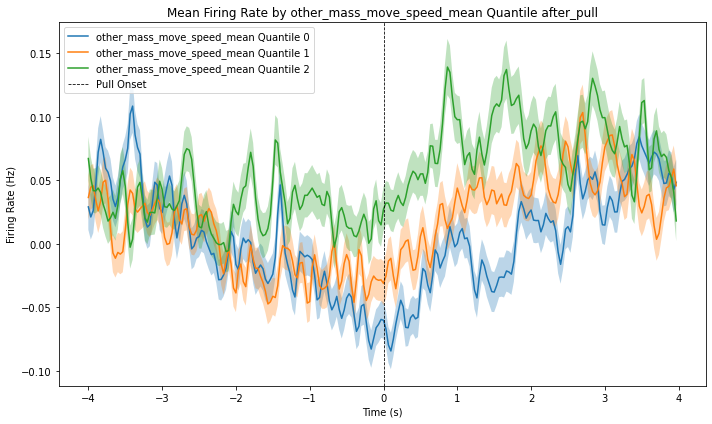

In [183]:
# step 1 - 2:
# do a basic plot for sanity check - mean FR across all units in the pool condition for each quantile
if 1:
    from scipy.integrate import cumtrapz

    doQuantMeanFRs = 1
    # only do one example session, all neurons in that session, average
    doExampleSession = 0
    # only do one example neuron in one example cell 
    doExampleNeuron = 0
    
    timewins = np.arange(-4, 4, 1/30)
    n_timepoints = len(timewins)
        
    #
    if doExampleSession:
        # examplesess = '20240606'
        examplesess =  '20240808'
        #
        if doQuantMeanFRs:
            ind = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df['session']==examplesess
            quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[ind][quantile_col].unique())
        else:
            ind = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session']==examplesess
            quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind][quantile_col].unique())      
    # 
    elif doExampleNeuron:
        examplesess =  '20240808'
        exampleneuron = '129'
        # 
        # has to do not QuantMeanFRs
        ind_1 = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['session']==examplesess
        ind_2 = bhvevents_aligned_FR_and_eventFeatures_all_dates_df['clusterID']==exampleneuron
        quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_1&ind_2][quantile_col].unique()) 
    #
    else:
        if doQuantMeanFRs:
            quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col].unique())
        else:
            quantile_values = np.sort(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[quantile_col].unique())
    
    quantile_values = quantile_values[~np.isnan(quantile_values)]
    
    y_label = 'Firing Rate (Hz)'
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if doExampleNeuron:
        ax2 = ax.twinx()  # Secondary y-axis for AUC

    for i_quantile, q_val in enumerate(quantile_values):
    
        #
        if doExampleSession:
            if doQuantMeanFRs:
                ind_quantile = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[ind][quantile_col] == q_val
                fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[ind][ind_quantile]['mean_FR_trace'].tolist())
            else:
                ind_quantile = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind][quantile_col] == q_val
                fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind][ind_quantile]['FR_ievent'].tolist())
        #
        elif doExampleNeuron:
            ind_quantile = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_1&ind_2][quantile_col] == q_val
            fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_1&ind_2][ind_quantile]['FR_ievent'].tolist())
            gaze_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_1&ind_2][ind_quantile][pull_trig_events_tgtname].tolist())
     
        #
        else:
            if doQuantMeanFRs:
                ind_quantile = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col] == q_val
                fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[ind_quantile]['mean_FR_trace'].tolist())
            else:
                ind_quantile = bhvevents_aligned_FR_and_eventFeatures_all_dates_df[quantile_col] == q_val
                fr_traces_quantile = np.vstack(bhvevents_aligned_FR_and_eventFeatures_all_dates_df[ind_quantile]['FR_ievent'].tolist())

            
        #     
        mean_fr = np.nanmean(fr_traces_quantile, axis=0)
        sem_fr = np.nanstd(fr_traces_quantile, axis=0) / np.sqrt(np.sum(~np.isnan(fr_traces_quantile[:, 0]))) # Standard Error of the Mean
        
        ax.plot(timewins, mean_fr, label=xxx_type+f' Quantile {int(q_val)}')
        ax.fill_between(timewins, mean_fr - sem_fr, mean_fr + sem_fr, alpha=0.3)

        
        #
        if doExampleNeuron:
            # Accumulated AUC for each gaze trace, then average
            auc_gaze_all = np.array([cumtrapz(trace, timewins, initial=0) for trace in gaze_traces_quantile])
            mean_auc_gaze = np.nanmean(auc_gaze_all, axis=0)
            sem_auc_gaze = np.nanstd(auc_gaze_all, axis=0) / np.sqrt(np.sum(~np.isnan(auc_gaze_all[:, 0])))
            
           #  # Plot AUC Gaze
           #  ax2.plot(timewins, mean_auc_gaze, linestyle='--', color='lightblue', label=f'Gaze AUC {int(q_val)}')
           #  ax2.fill_between(timewins, mean_auc_gaze - sem_auc_gaze, mean_auc_gaze + sem_auc_gaze, alpha=0.2, color='lightblue')

        
        
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(y_label)
    ax.set_title(f'Mean Firing Rate by {title_prefix} Quantile '+gaze_duration_type)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.8, label='Pull Onset')
    ax.legend()
    
    if doExampleNeuron:
        ax2.set_ylabel(xxx_type)
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    fig.tight_layout()

    
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FR_and_quantile_fig/"
    
        if doExampleSession:
            figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/"+examplesess+"/"
        
        if doExampleNeuron:
            figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/"+examplesess+"/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        if not doExampleNeuron:
            fig.savefig(figsavefolder+'bhvevents_aligned_averaged_FR_acrossNeurons_separate_quantiles_'+bhvname_ana+'_'+
                     xxx_type+'_'+gaze_duration_type+'_'+cond_toplot_type+savefile_sufix+'.pdf')
        elif doExampleNeuron:
            fig.savefig(figsavefolder+'bhvevents_aligned_averaged_FR_exampleNeurons_separate_quantiles_'+bhvname_ana+'_'+
                     xxx_type+'_'+gaze_duration_type+'_'+cond_toplot_type+savefile_sufix+'.pdf')
        

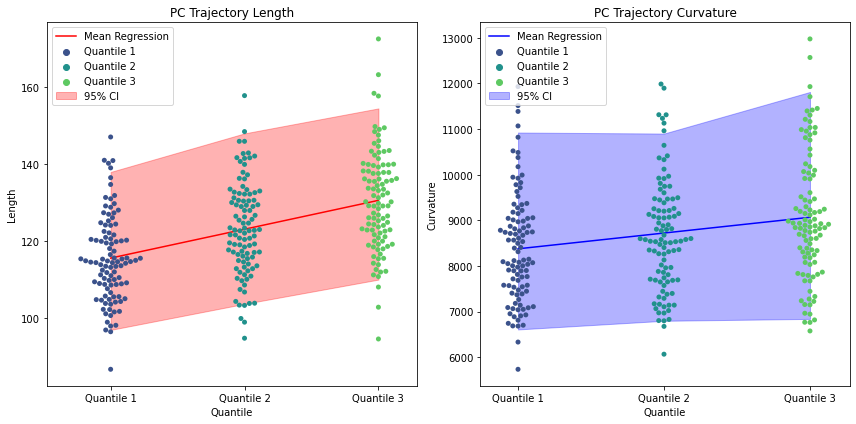

slopes of the length regressionT-statistic: 7.395517917220935; P-value: 4.617274109653004e-11
slopes of the curvature regressionT-statistic: 7.909059787929252; P-value: 3.7567685337999035e-12


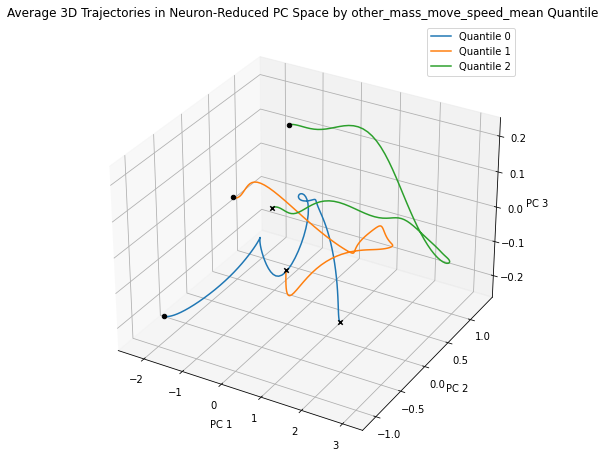


--- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---

Pairwise Paired t-tests for Length:
  Comparison       p_value   p_corrected  reject_null
0     (0, 1)  1.668644e-22  3.337287e-22         True
1     (0, 2)  4.250991e-40  1.275297e-39         True
2     (1, 2)  2.613480e-14  2.613480e-14         True

Pairwise Paired t-tests for Curvature:
  Comparison       p_value   p_corrected  reject_null
0     (0, 1)  9.887553e-04  9.887553e-04         True
1     (0, 2)  2.120080e-12  6.360241e-12         True
2     (1, 2)  2.063253e-06  4.126507e-06         True


In [184]:
# Step 2 - calculate the PCA with the pooled data

from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison

if 1:
    timewins = np.arange(-4, 4, 1 / 30)
    n_timepoints = len(timewins)
    quantile_col = xxx_type+'_quantile'  # Or 'gaze_duration_quantile'
    y_label = 'Firing Rate (Hz)'
    title_prefix = xxx_type  # Or 'Gaze Duration'
    smooth_kernel_size = 6
    n_bootstrap_iterations = 100
    n_neurons_to_sample = 200
    
    # Get unique neurons
    unique_neurons = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[['clusterID', 'session']].drop_duplicates()
    n_neurons = len(unique_neurons)

    # Get unique quantiles
    unique_quantiles = np.sort(bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col].unique())
    n_quantiles = len(unique_quantiles)

    # Initialize the data matrix
    data_matrix = np.empty((n_neurons, n_timepoints * n_quantiles))
    neuron_index_lookup = {}

    # Populate the data matrix
    neuron_counter = 0
    for neuron_row in unique_neurons.itertuples(index=False):
        cluster_id = neuron_row.clusterID
        session = neuron_row.session
        neuron_index_lookup[(cluster_id, session)] = neuron_counter
        neuron_counter += 1

        for i_quantile, q_val in enumerate(unique_quantiles):
            # Get the mean FR trace for the current neuron and quantile
            mean_fr_trace_df = bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df['clusterID'] == cluster_id) &
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df['session'] == session) &
                (bhvevents_aligned_FR_and_eventFeatures_meanFReachQuant_all_dates_df[quantile_col] == q_val)
            ]

            if not mean_fr_trace_df.empty:
                mean_fr_trace = mean_fr_trace_df['mean_FR_trace'].values[0]  # Take the first element
                data_matrix[neuron_index_lookup[(cluster_id, session)], i_quantile * n_timepoints:(i_quantile + 1) * n_timepoints] = mean_fr_trace
            else:
                data_matrix[neuron_index_lookup[(cluster_id, session)], i_quantile * n_timepoints:(i_quantile + 1) * n_timepoints] = np.nan  # Handle missing data

    # Prepare to store results
    all_quantile_lengths = np.zeros((n_bootstrap_iterations, n_quantiles))
    all_quantile_curvatures = np.zeros((n_bootstrap_iterations, n_quantiles))
    all_boot_pca_data = np.zeros((n_bootstrap_iterations, 10, n_timepoints * n_quantiles))  # Store all PCA results

    # Perform Bootstrapping
    for boot_iter in range(n_bootstrap_iterations):
        # 1. Randomly sample neurons
        sampled_neuron_indices = np.random.choice(n_neurons, n_neurons_to_sample, replace=True)
        sampled_data_matrix = data_matrix[sampled_neuron_indices, :].transpose()  # Neuron dimension becomes the columns

        # 2. Run PCA
        pca = PCA(n_components=10)  # Project to 10 PCs
        pca.fit(np.nan_to_num(sampled_data_matrix))
        pca_data = pca.transform(np.nan_to_num(sampled_data_matrix)).transpose()  # Project and transpose
        all_boot_pca_data[boot_iter, :, :] = pca_data

        # Calculate length and curvature for each quantile
        for i_quantile, q_val in enumerate(unique_quantiles):
            start_col = i_quantile * n_timepoints
            end_col = (i_quantile + 1) * n_timepoints
            quantile_data = pca_data[:, start_col:end_col]  # (10, n_timepoints)

            # 
            if gaze_duration_type == 'around_pull':
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, :], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, :], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors
            #
            elif gaze_duration_type == 'before_pull':
                ind_tgt = timewins<0
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, ind_tgt], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, ind_tgt], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors
            #
            elif gaze_duration_type == 'after_pull':
                ind_tgt = timewins>0
                # Calculate Length
                length = np.sum(np.sqrt(np.sum(np.diff(quantile_data[:10, ind_tgt], axis=1)**2, axis=0))) # Use only first 10 PCs
                all_quantile_lengths[boot_iter, i_quantile] = length

                # Calculate Curvature (using spline interpolation)
                t = np.linspace(0, 1, n_timepoints)
                try:
                    spl = splprep(quantile_data[:10, ind_tgt], s=0)  # Use only first 10 PCs, s=0 for no smoothing
                    spl_deriv2 = splev(t, spl[0], der=2)
                    curvature = np.mean(np.sqrt(spl_deriv2[0]**2 + spl_deriv2[1]**2 + spl_deriv2[2]**2))
                    all_quantile_curvatures[boot_iter, i_quantile] = curvature
                except:
                    all_quantile_curvatures[boot_iter, i_quantile] = np.nan  # Handle spline fitting errors

                    
    # ---plotting---
    # --- plotting number 1 ---
    # Plot Length and Curvature (as before)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Create a Pandas DataFrame for easier plotting with Seaborn
    df = pd.DataFrame(all_quantile_lengths, columns=[f'Quantile {i+1}' for i in range(num_quantiles)])
    # Melt the DataFrame to long format, which is ideal for Seaborn
    df_melted = pd.melt(df, var_name='Quantile Group', value_name='Length')
    # Create the swamp plot (also known as a violin plot)
    seaborn.swarmplot(ax = axes[0], x='Quantile Group', y='Length', data=df_melted, 
                      hue='Quantile Group', palette='viridis')
    #axes[0].boxplot(all_quantile_lengths)
    # axes[0].set_xticks(np.arange(1, n_quantiles + 1))
    axes[0].set_xlabel('Quantile')
    axes[0].set_ylabel('PC Trajectory Length')
    axes[0].set_title('Bootstrapped PC Trajectory Lengths')

    # Create a Pandas DataFrame for easier plotting with Seaborn
    df = pd.DataFrame(all_quantile_curvatures, columns=[f'Quantile {i+1}' for i in range(num_quantiles)])
    # Melt the DataFrame to long format, which is ideal for Seaborn
    df_melted = pd.melt(df, var_name='Quantile Group', value_name='Length')
    # Create the swamp plot (also known as a violin plot)
    seaborn.swarmplot(ax = axes[1], x='Quantile Group', y='Length', data=df_melted, 
                      hue='Quantile Group', palette='viridis')
    # axes[1].boxplot(all_quantile_curvatures)
    # axes[1].set_xticks(np.arange(1, n_quantiles + 1))
    axes[1].set_xlabel('Quantile')
    axes[1].set_ylabel('PC Trajectory Curvature')
    axes[1].set_title('Bootstrapped PC Trajectory Curvatures')

    # do the regression for each bootstrap iteration and then plot the average regression line
    from sklearn.linear_model import LinearRegression
    
    # Prepare x-axis (quantile indices)
    quantiles = np.arange(0, n_quantiles).reshape(-1, 1)

    # Store predicted regression lines from each bootstrap
    predicted_lengths = []
    predicted_curvatures = []
    reg_coeff_lengths = []
    reg_coeff_curvs = []

    for i in range(n_bootstrap_iterations):
        # Regression for length
        y_len = all_quantile_lengths[i]
        model_len = LinearRegression().fit(quantiles, y_len)
        slope = model_len.coef_
        reg_coeff_lengths.append(slope[0])
        pred_len = model_len.predict(quantiles)
        predicted_lengths.append(pred_len)

        # Regression for curvature
        y_curv = all_quantile_curvatures[i]
        model_curv = LinearRegression().fit(quantiles, y_curv)
        slope = model_curv.coef_
        reg_coeff_curvs.append(slope[0])
        pred_curv = model_curv.predict(quantiles)
        predicted_curvatures.append(pred_curv)

    # Convert to arrays
    predicted_lengths = np.array(predicted_lengths)
    predicted_curvatures = np.array(predicted_curvatures)

    # Mean and 95% CI across bootstraps
    mean_len = np.mean(predicted_lengths, axis=0)
    ci_len_low = np.percentile(predicted_lengths, 2.5, axis=0)
    ci_len_high = np.percentile(predicted_lengths, 97.5, axis=0)

    mean_curv = np.mean(predicted_curvatures, axis=0)
    ci_curv_low = np.percentile(predicted_curvatures, 2.5, axis=0)
    ci_curv_high = np.percentile(predicted_curvatures, 97.5, axis=0)

    # Length
    axes[0].plot(quantiles, mean_len, color='red', label='Mean Regression')
    axes[0].fill_between(quantiles.flatten(), ci_len_low, ci_len_high, color='red', alpha=0.3, label='95% CI')
    axes[0].set_title('PC Trajectory Length')
    axes[0].set_xlabel('Quantile')
    axes[0].set_ylabel('Length')
    axes[0].legend()

    # Curvature
    axes[1].plot(quantiles, mean_curv, color='blue', label='Mean Regression')
    axes[1].fill_between(quantiles.flatten(), ci_curv_low, ci_curv_high, color='blue', alpha=0.3, label='95% CI')
    axes[1].set_title('PC Trajectory Curvature')
    axes[1].set_xlabel('Quantile')
    axes[1].set_ylabel('Curvature')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    t_stat, p_value = stats.ttest_1samp(reg_coeff_lengths, 5)
    # Print the results
    print('slopes of the length regression'+f"T-statistic: {t_stat}"+'; '+f"P-value: {p_value}")
    #
    t_stat, p_value = stats.ttest_1samp(reg_coeff_curvs, 5)
    # Print the results
    print('slopes of the curvature regression'+f"T-statistic: {t_stat}"+'; '+f"P-value: {p_value}")

    # --- plotting number 1 end ---


    
    
    
    # Plot Average 3D Traces
    fig2 = plt.figure(figsize=(10, 8))
    ax = fig2.add_subplot(111, projection='3d')

    mean_traces_3d = np.mean(all_boot_pca_data[:, :3, :], axis=0)  # Average across bootstrap iterations, use only first 3 PCs

    for i_quantile, q_val in enumerate(unique_quantiles):
        start_col = i_quantile * n_timepoints
        end_col = (i_quantile + 1) * n_timepoints
        mean_quantile_data = mean_traces_3d[:, start_col:end_col]

        # Smooth the trajectory
        smooth_x = gaussian_filter1d(mean_quantile_data[0, ind_tgt], sigma=smooth_kernel_size)
        smooth_y = gaussian_filter1d(mean_quantile_data[1, ind_tgt], sigma=smooth_kernel_size)
        smooth_z = gaussian_filter1d(mean_quantile_data[2, ind_tgt], sigma=smooth_kernel_size)

        # Plot the smoothed trajectory
        ax.plot(smooth_x, smooth_y, smooth_z, label=f'Quantile {int(q_val)}')

        # Mark start and end points
        ax.scatter(smooth_x[0], smooth_y[0], smooth_z[0], marker='o', color='k')  # Start
        ax.scatter(smooth_x[-1], smooth_y[-1], smooth_z[-1], marker='x', color='k')  # End

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'Average 3D Trajectories in Neuron-Reduced PC Space by {title_prefix} Quantile')
    ax.legend()
    plt.show()

    # --- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---
    print("\n--- Statistical Analysis (Paired t-tests with Holm-Bonferroni) ---")

    from scipy import stats
    from statsmodels.sandbox.stats.multicomp import multipletests

    def perform_pairwise_paired_ttests(data, group_labels, alpha=0.01):
        unique_groups = np.unique(group_labels)
        n_groups = len(unique_groups)
        p_values = []
        comparisons = []

        for i in range(n_groups):
            for j in range(i + 1, n_groups):
                group1_data = data[:, i]
                group2_data = data[:, j]
                t_stat, p_val = stats.ttest_rel(group1_data, group2_data)
                p_values.append(p_val)
                comparisons.append((unique_groups[i], unique_groups[j]))

        reject, p_corrected, _, _ = multipletests(p_values, method='holm', alpha=alpha)

        results_df = pd.DataFrame({'Comparison': comparisons,
                                   'p_value': p_values,
                                   'p_corrected': p_corrected,
                                   'reject_null': reject})
        return results_df

    # Perform pairwise paired t-tests for Length
    length_pairwise_results = perform_pairwise_paired_ttests(all_quantile_lengths, unique_quantiles)
    print("\nPairwise Paired t-tests for Length:")
    print(length_pairwise_results)

    # Perform pairwise paired t-tests for Curvature
    curvature_pairwise_results = perform_pairwise_paired_ttests(all_quantile_curvatures, unique_quantiles)
    print("\nPairwise Paired t-tests for Curvature:")
    print(curvature_pairwise_results)
    
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+"fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartfocused_continuousBhv_partnerDistVaris/"+\
                        cameraID+"/"+animal1_filenames[0]+"_"+animal2_filenames[0]+"/FR_and_quantile_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder+'bhvevents_aligned_PCfeatures_sparate_quantiles_'+bhvname_ana+'_'+
                     xxx_type+'_'+gaze_duration_type+'_'+cond_toplot_type+savefile_sufix+'.pdf')
        
        fig2.savefig(figsavefolder+'bhvevents_aligned_PCtrajectory_sparate_quantiles_'+bhvname_ana+'_'+
                     xxx_type+'_'+gaze_duration_type+'_'+cond_toplot_type+savefile_sufix+'.pdf')
    
    
    

In [185]:
quantile_col

'other_mass_move_speed_mean_quantile'

In [186]:
np.shape(sampled_data_matrix)

(720, 200)